## Chanuka Clustering

In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from matplotlib_venn import venn3
import numpy as np
# to view all columns in a dataframe
pd.set_option('display.max_columns', None)

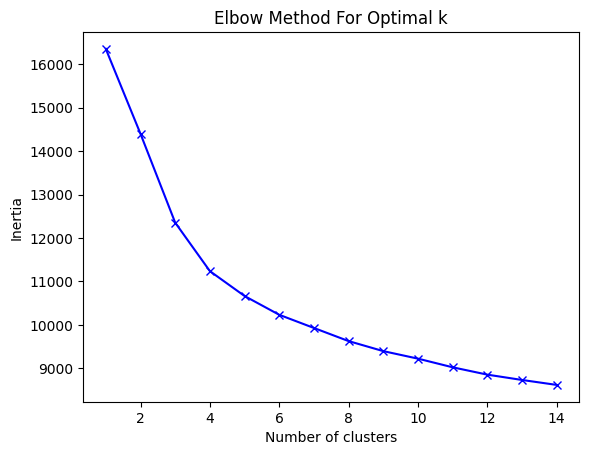

Text(0, 0.5, 'Principal Component 2')

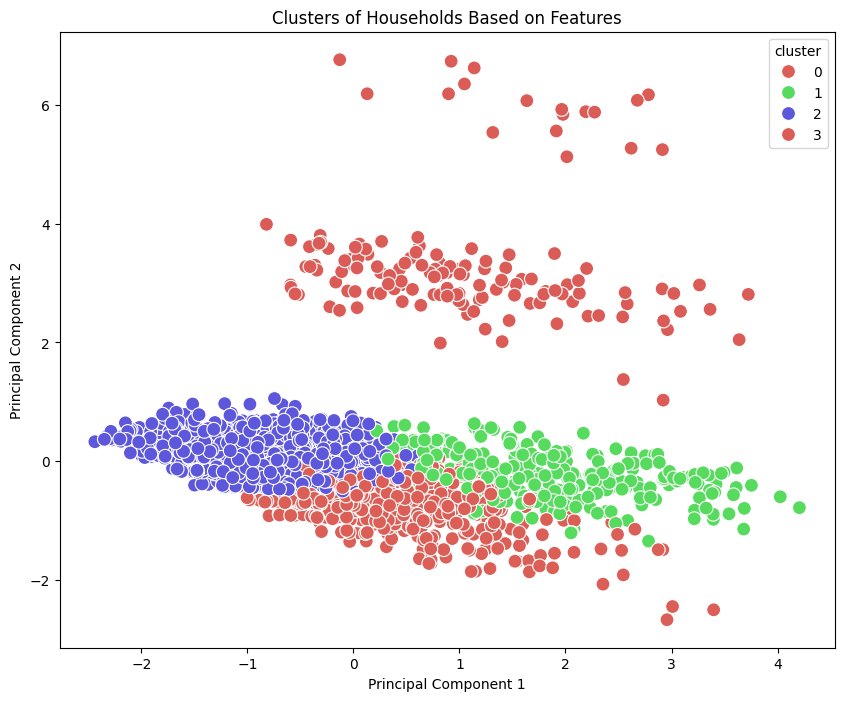

In [2]:
data_survey = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_household_information_and_history.csv')
generation = pd.read_csv('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_electricity_generation_water_heating_cooking.csv')
generation.fillna({'solar_system_ongrid_or_offgird': 'No'}, inplace=True)

data_survey = data_survey.merge(generation[['household_ID', 'solar_system_ongrid_or_offgird']], on='household_ID', how='left')

data = data_survey[['household_ID', 'is_there_business_carried_out_in_the_household',
             'total_monthly_expenditure_of_last_month',
             'no_of_household_members',
             'type_of_electricity_meter',
             'socio_economic_class',
             'occupy_renters_boarders',
             'no_of_electricity_meters',
             'type_of_house',
             'main_material_used_for_walls_of_the_house',
             'main_material_used_for_roof_of_the_house',
             'built_year_of_the_house', 'solar_system_ongrid_or_offgird']].copy()

data.dropna(inplace=True)

household_ids = data['household_ID'].copy()
data.drop(columns=['household_ID'], inplace=True)

categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = encoder.fit_transform(data[categorical_cols])

scaler = StandardScaler()
X_num = scaler.fit_transform(data[numerical_cols])
X = np.hstack([X_num, X_cat])

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

data['household_ID'] = household_ids.values  # re-add ID
data['cluster'] = clusters

inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Visualizing clusters using principle component analysis (PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['cluster'], palette='hls', s=100)
plt.title('Clusters of Households Based on Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [3]:
# Analyze cluster distribution
print("=== CLUSTER ANALYSIS ===")
print(f"Total households: {len(data)}")
print("\nCluster distribution:")
cluster_counts = data['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(data)) * 100
    print(f"Cluster {cluster}: {count} households ({percentage:.1f}%)")

# Display cluster characteristics
print("\n=== CLUSTER CHARACTERISTICS ===")
categorical_summary = data.groupby('cluster')[categorical_cols].agg(lambda x: x.value_counts().index[0] if len(x) > 0 else 'N/A')
numerical_summary = data.groupby('cluster')[numerical_cols].mean().round(2)

print("\nNumerical characteristics by cluster:")
print(numerical_summary)

print("\nCategorical characteristics by cluster (most common value):")
print(categorical_summary)

=== CLUSTER ANALYSIS ===
Total households: 2322

Cluster distribution:
Cluster 0: 699 households (30.1%)
Cluster 1: 315 households (13.6%)
Cluster 2: 1159 households (49.9%)
Cluster 3: 149 households (6.4%)

=== CLUSTER CHARACTERISTICS ===

Numerical characteristics by cluster:
         total_monthly_expenditure_of_last_month  no_of_household_members  \
cluster                                                                     
0                                       64957.08                     5.89   
1                                      150476.19                     4.35   
2                                       50744.18                     2.94   
3                                       74711.41                     3.93   

         no_of_electricity_meters  
cluster                            
0                            1.00  
1                            1.00  
2                            1.00  
3                            2.12  

Categorical characteristics by cluster (m

In [4]:
# Save household IDs for each cluster
print("=== SAVING HOUSEHOLD IDs BY CLUSTER ===")

unique_clusters = sorted(data['cluster'].unique())
cluster_households = {}

for cluster_id in unique_clusters:
    # Get household IDs for this cluster
    household_ids_in_cluster = data[data['cluster'] == cluster_id]['household_ID'].tolist()
    cluster_households[f'cluster_{cluster_id}'] = household_ids_in_cluster
    
    # Save to CSV file (just household IDs)
    cluster_df = pd.DataFrame({'household_ID': household_ids_in_cluster})
    csv_filename = f'cluster_{cluster_id}_households.csv'
    cluster_df.to_csv(csv_filename, index=False)
    
    print(f"Cluster {cluster_id}: {len(household_ids_in_cluster)} households")
    print(f"  - Variable: cluster_households['cluster_{cluster_id}']")
    print(f"  - CSV file: {csv_filename}")
    print(f"  - First 5 IDs: {household_ids_in_cluster[:5]}")
    print()

# Also create individual variables for easy access
cluster_0_households = cluster_households['cluster_0']
cluster_1_households = cluster_households['cluster_1']
cluster_2_households = cluster_households['cluster_2']
cluster_3_households = cluster_households['cluster_3']

print("You can now access household IDs using:")
print("  cluster_0_households, cluster_1_households, cluster_2_households, cluster_3_households")
print("  or cluster_households['cluster_X']")

=== SAVING HOUSEHOLD IDs BY CLUSTER ===
Cluster 0: 699 households
  - Variable: cluster_households['cluster_0']
  - CSV file: cluster_0_households.csv
  - First 5 IDs: ['ID0006', 'ID0010', 'ID0011', 'ID0016', 'ID0019']

Cluster 1: 315 households
  - Variable: cluster_households['cluster_1']
  - CSV file: cluster_1_households.csv
  - First 5 IDs: ['ID0003', 'ID0004', 'ID0012', 'ID0018', 'ID0022']

Cluster 2: 1159 households
  - Variable: cluster_households['cluster_2']
  - CSV file: cluster_2_households.csv
  - First 5 IDs: ['ID0001', 'ID0002', 'ID0005', 'ID0007', 'ID0009']

Cluster 3: 149 households
  - Variable: cluster_households['cluster_3']
  - CSV file: cluster_3_households.csv
  - First 5 IDs: ['ID0008', 'ID0021', 'ID0050', 'ID0052', 'ID0081']

You can now access household IDs using:
  cluster_0_households, cluster_1_households, cluster_2_households, cluster_3_households
  or cluster_households['cluster_X']


## Cluster-Based Anomaly Detection

This section identifies anomalous households for each cluster using autoencoder analysis.
Only households that belong to a cluster AND are present in the 6-hour interval data will be analyzed.

In [5]:
# Load required libraries for anomaly detection
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Load 6-hour interval consumption data
DATA_DIR = Path('/home/ranushi/test/Anomaly DetectionMethod/6hour_interval')
HH_ID_COL_CANDIDATES = ['household_ID', 'household_id', 'hhid', 'HHID']
MEMBERS_COL_CANDIDATES = ['no_of_household_members', 'household_size', 'num_members', 'members']

def pick_first_present(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f'None of the candidate columns {candidates} found in dataframe columns: {df.columns.tolist()}')

# Load smart meter 6-hour interval data
all_data = []
for csv_path in DATA_DIR.glob('*.csv'):
    try:
        df = pd.read_csv(csv_path, low_memory=False)
        all_data.append(df)
        print(f'Loaded {csv_path.name}: {df.shape}')
    except Exception as e:
        print(f'Skipping {csv_path}: {e}')

if not all_data:
    raise RuntimeError('No 6-hour interval CSV files loaded.')

raw_df = pd.concat(all_data, ignore_index=True)
print(f'Combined data shape: {raw_df.shape}')

2025-09-19 16:54:46.592274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758281086.606429 2727752 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758281086.610897 2727752 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758281086.622010 2727752 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758281086.622025 2727752 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758281086.622026 2727752 computation_placer.cc:177] computation placer alr

Loaded smart_6hour_1.csv: (1115230, 32)
Loaded smart_6hour_4.csv: (680674, 32)
Loaded smart_6hour_4.csv: (680674, 32)
Loaded smart_6hour_3.csv: (1047075, 32)
Loaded smart_6hour_3.csv: (1047075, 32)
Loaded smart_6hour_2.csv: (1319347, 32)
Loaded smart_6hour_2.csv: (1319347, 32)
Loaded smart_6hour_5.csv: (279467, 32)
Loaded smart_6hour_5.csv: (279467, 32)
Combined data shape: (4441793, 32)
Combined data shape: (4441793, 32)


In [6]:
# Process 6-hour interval data
hh_id_col = pick_first_present(raw_df, HH_ID_COL_CANDIDATES)
DATE_COL = 'DATE'
TIME_COL = 'TIME'
KWH_COL = 'TOTAL_IMPORT (kWh)'

cols_needed = [hh_id_col, DATE_COL, TIME_COL, KWH_COL]
missing = [c for c in cols_needed if c not in raw_df.columns]
if missing:
    raise KeyError(f'Missing required columns in smart meter data: {missing}')

raw_df = raw_df[cols_needed].copy()
raw_df[TIME_COL] = raw_df[TIME_COL].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})')
raw_df['DATETIME'] = pd.to_datetime(raw_df[DATE_COL] + ' ' + raw_df[TIME_COL], errors='coerce')
raw_df[KWH_COL] = pd.to_numeric(raw_df[KWH_COL], errors='coerce')
raw_df = raw_df.dropna(subset=['DATETIME'])
raw_df = raw_df.sort_values([hh_id_col, 'DATETIME'])

# Convert cumulative import to interval consumption (diff per 6h)
raw_df[KWH_COL] = raw_df.groupby(hh_id_col)[KWH_COL].diff()

# Floor to 6h and deduplicate
raw_df['DATETIME'] = raw_df['DATETIME'].dt.floor('6h')
raw_df = raw_df.drop_duplicates(subset=[hh_id_col, 'DATETIME'])

# Pivot to time x household matrix
pivot_df = raw_df.pivot(index='DATETIME', columns=hh_id_col, values=KWH_COL)
pivot_df = pivot_df.sort_index()

# Fill missing values
pivot_df = pivot_df.ffill().bfill()

# Keep households with at least 40% data coverage
min_required = int(0.4 * len(pivot_df))
pivot_df = pivot_df.dropna(axis=1, thresh=min_required)

print(f'Households after cleaning: {pivot_df.shape[1]}')
print(f'Time periods: {pivot_df.shape[0]}')

Households after cleaning: 2950
Time periods: 2734


In [7]:
# Compute per-capita consumption
# Get household member data
members_col = pick_first_present(data, MEMBERS_COL_CANDIDATES)
hh_info_id_col = 'household_ID'

# Create members mapping
members_map = dict(zip(data[hh_info_id_col], data[members_col]))
members_series = pd.Series(members_map)

# Find common households between clustering data and 6-hour data
common_households = sorted(set(pivot_df.columns).intersection(set(data[hh_info_id_col])))
pivot_df_common = pivot_df[common_households].copy()

print(f'Common households between clustering and 6-hour data: {len(common_households)}')

# Compute per-capita consumption
per_capita_df = pivot_df_common / members_series
per_capita_df = per_capita_df.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')

print(f'Households after per-capita cleanup: {per_capita_df.shape[1]}')

# Check overlap with cluster data
available_6hour_households = set([str(h) for h in per_capita_df.columns])
print(f"Households in 6-hour interval data: {len(available_6hour_households)}")

Common households between clustering and 6-hour data: 780
Households after per-capita cleanup: 780
Households in 6-hour interval data: 780
Households after per-capita cleanup: 780
Households in 6-hour interval data: 780


In [8]:
# Find intersection between cluster households and 6-hour data
cluster_6hour_intersection = {}
total_intersecting = 0

print("=== CLUSTER-6HOUR DATA INTERSECTION ===")
for cluster_id in unique_clusters:
    cluster_hh = set([str(h) for h in cluster_households[f'cluster_{cluster_id}']])
    intersection = cluster_hh.intersection(available_6hour_households)
    cluster_6hour_intersection[cluster_id] = intersection
    print(f"Cluster {cluster_id}: {len(intersection)} households in both cluster and 6-hour data")
    total_intersecting += len(intersection)

print(f"Total households for analysis: {total_intersecting}")

=== CLUSTER-6HOUR DATA INTERSECTION ===
Cluster 0: 210 households in both cluster and 6-hour data
Cluster 1: 132 households in both cluster and 6-hour data
Cluster 2: 355 households in both cluster and 6-hour data
Cluster 3: 83 households in both cluster and 6-hour data
Total households for analysis: 780


In [9]:
# Helper functions for anomaly detection
def build_sequences(array_2d: np.ndarray, seq_len: int) -> np.ndarray:
    """Convert 2D array (time, features) into rolling window sequences."""
    sequences = []
    for i in range(len(array_2d) - seq_len + 1):
        sequences.append(array_2d[i:i + seq_len])
    return np.array(sequences)

def build_autoencoder(n_features: int, seq_len: int, latent_units: int = 128) -> Model:
    """Build LSTM sequence autoencoder."""
    inp = Input(shape=(seq_len, n_features))
    encoded = LSTM(latent_units, activation='relu', return_sequences=False)(inp)
    decoded = RepeatVector(seq_len)(encoded)
    decoded = LSTM(latent_units, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(n_features))(decoded)
    model = Model(inp, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model

def detect_anomalies(sequences: np.ndarray, model: Model, seq_pct: float, hh_pct: float, 
                    epochs: int, batch_size: int, random_state: int = 42):
    """Train model, detect anomalous sequences & households."""
    X_train, X_val = train_test_split(sequences, test_size=0.2, random_state=random_state)
    history = model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, X_val),
        verbose=0
    )

    reconstructed = model.predict(sequences, verbose=0)
    seq_errors = np.mean(np.square(sequences - reconstructed), axis=(1, 2))

    # Threshold for anomalous sequences
    seq_threshold = np.percentile(seq_errors, seq_pct)
    seq_anom_mask = seq_errors > seq_threshold

    anomalous_sequences = sequences[seq_anom_mask]
    anomalous_recon = reconstructed[seq_anom_mask]

    # Per-household contribution
    per_hh_errors = np.square(anomalous_sequences - anomalous_recon)
    hh_errors = per_hh_errors.mean(axis=(0, 1))  # average over sequences & timesteps
    hh_threshold = np.percentile(hh_errors, hh_pct)
    hh_anom_idx = np.where(hh_errors > hh_threshold)[0]

    return {
        'history': history,
        'sequence_errors': seq_errors,
        'sequence_threshold': seq_threshold,
        'sequence_anomaly_mask': seq_anom_mask,
        'household_errors': hh_errors,
        'household_threshold': hh_threshold,
        'household_anom_indices': hh_anom_idx
    }

In [13]:
# Configuration for cluster-based anomaly detection
EPOCHS_CLUSTER = 20
BATCH_SIZE_CLUSTER = 32
SEQUENCE_LENGTH_CLUSTER = 30
SEQ_ANOMALY_PCT_CLUSTER = 80
HH_ANOMALY_PCT_CLUSTER = 80
RANDOM_STATE_CLUSTER = 42

# Main anomaly detection loop for each cluster
results_summary_cluster = []
per_cluster_anomalies = {}

print("=== STARTING CLUSTER-BASED ANOMALY DETECTION ===")

for cluster_id, hh_ids_set in cluster_6hour_intersection.items():
    if len(hh_ids_set) == 0:
        print(f"\nSkipping Cluster {cluster_id}: No households in intersection")
        continue
        
    print(f"\n=== Processing Cluster {cluster_id} ===")
    
    # Convert set to list for indexing
    hh_ids = list(hh_ids_set)
    
    # Get per-capita consumption data for this cluster
    cluster_df = per_capita_df[hh_ids].copy()
    
    print(f"Cluster {cluster_id} - Households: {len(hh_ids)}, Time periods: {len(cluster_df)}")
    
    # Scale each household (feature) across time
    scaler = MinMaxScaler()
    norm_vals = scaler.fit_transform(cluster_df.values)  # shape (time, households)
    
    # Build sequences
    sequences = build_sequences(norm_vals, SEQUENCE_LENGTH_CLUSTER)
    
    if sequences.shape[0] < 20:
        print(f"Warning: Only {sequences.shape[0]} sequences for Cluster {cluster_id}; results may be unstable.")
        # Skip clusters with too few sequences
        if sequences.shape[0] < 10:
            print(f"Skipping Cluster {cluster_id}: Too few sequences ({sequences.shape[0]})")
            continue
    
    # Build autoencoder model
    model = build_autoencoder(
        n_features=norm_vals.shape[1],
        seq_len=SEQUENCE_LENGTH_CLUSTER,
        latent_units=min(128, max(16, norm_vals.shape[1] * 2))
    )
    
    # Detect anomalies
    det = detect_anomalies(
        sequences, model, SEQ_ANOMALY_PCT_CLUSTER, HH_ANOMALY_PCT_CLUSTER,
        EPOCHS_CLUSTER, BATCH_SIZE_CLUSTER, random_state=RANDOM_STATE_CLUSTER
    )
    
    # Get anomalous household IDs
    anom_households = [hh_ids[i] for i in det['household_anom_indices']]
    per_cluster_anomalies[cluster_id] = anom_households
    
    # Save anomalies for this cluster
    out_csv = f"anomalous_households_autoencoder_cluster_{cluster_id}.csv"
    pd.DataFrame({
        'household_ID': anom_households,
        'cluster_id': cluster_id,
        'per_capita': True
    }).to_csv(out_csv, index=False)
    
    print(f"Anomalous households in Cluster {cluster_id}: {len(anom_households)} (saved to {out_csv})")
    
    # Store results
    results_summary_cluster.append({
        'cluster_id': cluster_id,
        'total_households': len(hh_ids),
        'anomalous_households': len(anom_households),
        'sequence_threshold': float(det['sequence_threshold']),
        'household_threshold': float(det['household_threshold']),
        'anomaly_percentage': (len(anom_households) / len(hh_ids)) * 100 if len(hh_ids) > 0 else 0
    })

print("\n=== CLUSTER ANOMALY DETECTION COMPLETED ===")

=== STARTING CLUSTER-BASED ANOMALY DETECTION ===

=== Processing Cluster 0 ===
Cluster 0 - Households: 210, Time periods: 2734


2025-09-19 16:56:55.690599: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 52.01MiB (rounded to 54532864)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-09-19 16:56:55.690652: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1058] BFCAllocator dump for GPU_0_bfc
2025-09-19 16:56:55.690672: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (256): 	Total Chunks: 27, Chunks in use: 27. 6.8KiB allocated for chunks. 6.8KiB in use in bin. 208B client-requested in use in bin.
2025-09-19 16:56:55.690684: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1065] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2025-09-19 16:56:55.6906

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [12]:
# Save results and create summary
if results_summary_cluster:
    summary_cluster_df = pd.DataFrame(results_summary_cluster)
    summary_cluster_df.to_csv('anomalous_households_autoencoder_summary_by_cluster.csv', index=False)
    
    print('\nSummary by Cluster:')
    print(summary_cluster_df)
    
    # Create combined anomalies file (all clusters)
    combined_cluster_rows = []
    for cluster_id, hh_list in per_cluster_anomalies.items():
        for h in hh_list:
            combined_cluster_rows.append({'household_ID': h, 'cluster_id': cluster_id})
    
    if combined_cluster_rows:
        combined_cluster_df = pd.DataFrame(combined_cluster_rows).drop_duplicates()
        combined_cluster_df.to_csv('anomalous_households_autoencoder_per_capita_all_clusters.csv', index=False)
        print(f'\nTotal anomalous households (unique across clusters): {combined_cluster_df.shape[0]}')
        print('Saved to: anomalous_households_autoencoder_per_capita_all_clusters.csv')
        
        # Display sample results
        print('\nSample results:')
        print(combined_cluster_df.head(10))
    else:
        print('\nNo anomalous households found across any cluster.')
else:
    print('\nNo clusters were processed successfully.')


No clusters were processed successfully.


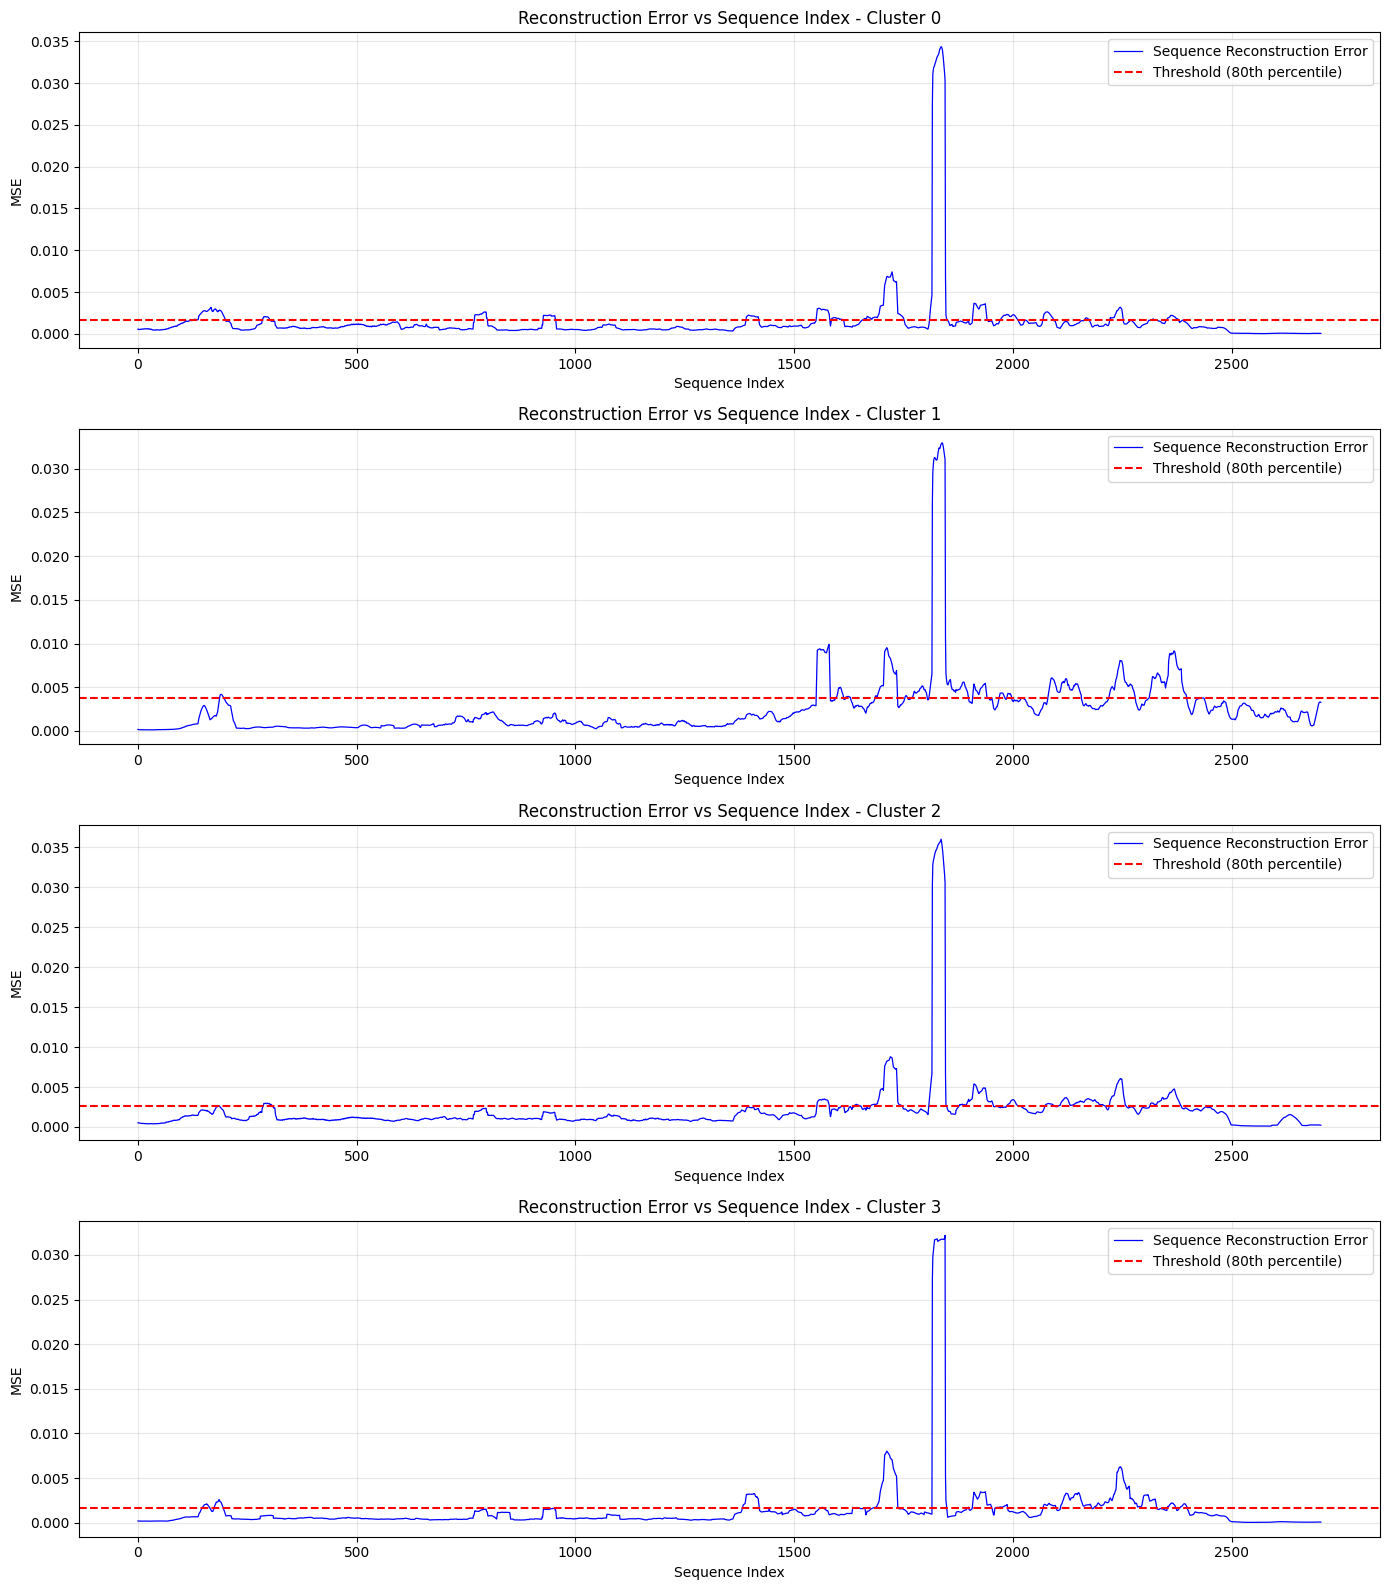

In [16]:
# Visualization: Reconstruction error plots for each cluster
if per_cluster_anomalies:
    # Create reconstruction error plots for each cluster
    n_clusters = len([k for k in per_cluster_anomalies.keys() if len(per_cluster_anomalies[k]) > 0])
    
    if n_clusters > 0:
        fig, axes = plt.subplots(n_clusters, 1, figsize=(14, 4*n_clusters))
        if n_clusters == 1:
            axes = [axes]
        
        plot_index = 0
        
        for cluster_id, hh_ids_set in cluster_6hour_intersection.items():
            if len(hh_ids_set) == 0:
                continue
                
            hh_ids = list(hh_ids_set)
            cluster_df = per_capita_df[hh_ids].copy()
            
            if len(cluster_df) < SEQUENCE_LENGTH_CLUSTER:
                continue
                
            # Recreate the analysis for plotting
            scaler = MinMaxScaler()
            norm_vals = scaler.fit_transform(cluster_df.values)
            sequences = build_sequences(norm_vals, SEQUENCE_LENGTH_CLUSTER)
            
            if sequences.shape[0] < 10:
                continue
                
            model = build_autoencoder(
                n_features=norm_vals.shape[1],
                seq_len=SEQUENCE_LENGTH_CLUSTER,
                latent_units=min(128, max(16, norm_vals.shape[1] * 2))
            )
            
            det = detect_anomalies(
                sequences, model, SEQ_ANOMALY_PCT_CLUSTER, HH_ANOMALY_PCT_CLUSTER,
                EPOCHS_CLUSTER, BATCH_SIZE_CLUSTER, random_state=RANDOM_STATE_CLUSTER
            )
            
            seq_errors = det['sequence_errors']
            seq_threshold = det['sequence_threshold']
            
            ax = axes[plot_index]
            ax.plot(seq_errors, label='Sequence Reconstruction Error', linewidth=0.9, color='blue')
            ax.axhline(seq_threshold, color='red', linestyle='--', 
                      label=f'Threshold ({SEQ_ANOMALY_PCT_CLUSTER}th percentile)')
            ax.set_title(f'Reconstruction Error vs Sequence Index - Cluster {cluster_id}')
            ax.set_xlabel('Sequence Index')
            ax.set_ylabel('MSE')
            ax.legend(loc='upper right')
            ax.grid(True, alpha=0.3)
            
            plot_index += 1
        
        plt.tight_layout()
        plt.show()
    else:
        print('No clusters available for visualization.')
else:
    print('No anomaly detection results available for visualization.')

In [17]:
# Final summary and statistics
if 'summary_cluster_df' in locals():
    print('\n=== FINAL CLUSTER RESULTS SUMMARY ===')
    total_analyzed = summary_cluster_df['total_households'].sum()
    total_anomalous = summary_cluster_df['anomalous_households'].sum()
    overall_anomaly_rate = (total_anomalous / total_analyzed) * 100 if total_analyzed > 0 else 0
    
    print(f'Total households analyzed: {total_analyzed}')
    print(f'Total anomalous households: {total_anomalous}')
    print(f'Overall anomaly rate: {overall_anomaly_rate:.2f}%')
    
    print('\nPer-cluster breakdown:')
    print(summary_cluster_df[['cluster_id', 'total_households', 'anomalous_households', 'anomaly_percentage']])
    
    # Save detailed cluster information
    cluster_details = []
    for cluster_id in unique_clusters:
        cluster_data = data[data['cluster'] == cluster_id]
        if cluster_id in per_cluster_anomalies:
            anomalous_count = len(per_cluster_anomalies[cluster_id])
        else:
            anomalous_count = 0
            
        cluster_details.append({
            'cluster_id': cluster_id,
            'total_households_in_cluster': len(cluster_data),
            'households_with_6hour_data': len(cluster_6hour_intersection.get(cluster_id, [])),
            'anomalous_households': anomalous_count,
            'avg_monthly_expenditure': cluster_data['total_monthly_expenditure_of_last_month'].mean(),
            'avg_household_members': cluster_data['no_of_household_members'].mean(),
            'most_common_sec': cluster_data['socio_economic_class'].value_counts().index[0] if len(cluster_data) > 0 else 'N/A'
        })
    
    cluster_details_df = pd.DataFrame(cluster_details)
    cluster_details_df.to_csv('cluster_anomaly_detection_details.csv', index=False)
    print('\nDetailed cluster information saved to: cluster_anomaly_detection_details.csv')
    print('\nCluster Details:')
    print(cluster_details_df)
else:
    print('\nNo cluster analysis results available.')


=== FINAL CLUSTER RESULTS SUMMARY ===
Total households analyzed: 780
Total anomalous households: 157
Overall anomaly rate: 20.13%

Per-cluster breakdown:
   cluster_id  total_households  anomalous_households  anomaly_percentage
0           0               210                    42           20.000000
1           1               132                    27           20.454545
2           2               355                    71           20.000000
3           3                83                    17           20.481928

Detailed cluster information saved to: cluster_anomaly_detection_details.csv

Cluster Details:
   cluster_id  total_households_in_cluster  households_with_6hour_data  \
0           0                          699                         210   
1           1                          315                         132   
2           2                         1159                         355   
3           3                          149                          83   

   anoma

## Appliance Data Analysis by Cluster

Load and analyze appliance usage data for each cluster to understand
household appliance patterns and compare anomalous vs normal households within clusters.

In [18]:
# Load and engineer appliance features (counts & average weekly usage hours per appliance_type)
import seaborn as sns
import os
from pathlib import Path

APPLIANCE_PATH_CANDIDATES = [
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_appliance.csv'), 
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_appliances.csv'), 
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/appliance.csv'),
    Path('wave_1/w1_appliance.csv'), 
    Path('wave_1/w1_appliances.csv'), 
    Path('wave_1/appliance.csv')
]

def first_existing_path(paths):
    for p in paths:
        if p.exists():
            return p
    raise FileNotFoundError(f'None of expected appliance files found: {paths}')

appliance_path = first_existing_path(APPLIANCE_PATH_CANDIDATES)
app_df = pd.read_csv(appliance_path, low_memory=False)

# Standardize column names
app_df.columns = [c.strip().lower().replace(' ', '_') for c in app_df.columns]

# Identify columns (robust to naming)
APP_HH_COL = next(c for c in app_df.columns if 'household' in c and 'id' in c)
APP_TYPE_COL = next(c for c in app_df.columns if 'appliance_type' in c or c.endswith('type'))
APP_ID_COL = next(c for c in app_df.columns if c.startswith('appliance_id') or c=='appliance_id')
HOURS_COL = next((c for c in app_df.columns if 'hours' in c and 'week' in c), None)

if HOURS_COL is None: 
    raise KeyError('Could not locate hours usage column in appliance file.')

app_df[HOURS_COL] = pd.to_numeric(app_df[HOURS_COL], errors='coerce')

print(f'Loaded appliance data: {app_df.shape}')
print(f'Columns found: HH_COL={APP_HH_COL}, TYPE_COL={APP_TYPE_COL}, ID_COL={APP_ID_COL}, HOURS_COL={HOURS_COL}')

Loaded appliance data: (53599, 4)
Columns found: HH_COL=household_id, TYPE_COL=appliance_type, ID_COL=appliance_id, HOURS_COL=no_of_hours_used_during_last_week


In [19]:
# Aggregate per household + appliance_type
appliance_stats = (app_df.groupby([APP_HH_COL, APP_TYPE_COL])
                       .agg(count=(APP_ID_COL,'nunique'), mean_hours=(HOURS_COL,'mean'))
                       .reset_index())

# Pivot counts
counts_wide = appliance_stats.pivot(index=APP_HH_COL, columns=APP_TYPE_COL, values='count')
counts_wide.columns = [f'count__{c}' for c in counts_wide.columns]

# Pivot mean hours
hours_wide = appliance_stats.pivot(index=APP_HH_COL, columns=APP_TYPE_COL, values='mean_hours')
hours_wide.columns = [f'hours__{c}' for c in hours_wide.columns]

appliance_features = counts_wide.join(hours_wide, how='outer')

print(f'Appliance features matrix shape: {appliance_features.shape}')
print(f'Sample appliance types: {list(hours_wide.columns[:5])}')

Appliance features matrix shape: (4055, 154)
Sample appliance types: ['hours__Air fryer', 'hours__Bluetooth Speakers', 'hours__CCTV camera systems', 'hours__Camera (that needs to be charged using electricity)', 'hours__Clothes dryer']


In [20]:
# Add special device features (AC, Fan, Bulb) with day/night usage patterns
def _load_special(paths, device_label, day_kw='day', night_kw='night'):
    path = first_existing_path(paths) if paths else None
    if path is None:
        print(f'No file found for {device_label}; skipping.')
        return None
    
    try:
        df = pd.read_csv(path, low_memory=False)
        # standardize cols
        df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
        
        # pick columns
        hh_col = next(c for c in df.columns if 'household' in c and 'id' in c)
        cand_ids = [c for c in df.columns if c.endswith('_id') and c != hh_col]
        device_id_col = cand_ids[0] if cand_ids else None
        day_cols = [c for c in df.columns if day_kw in c and 'hour' in c]
        night_cols = [c for c in df.columns if night_kw in c and 'hour' in c]
        day_col = max(day_cols, key=len) if day_cols else None
        night_col = max(night_cols, key=len) if night_cols else None
        
        if day_col is None or night_col is None:
            print(f'Could not identify day/night hour columns for {device_label}; skipping.')
            return None
            
        for c in [day_col, night_col]:
            df[c] = pd.to_numeric(df[c], errors='coerce')
        df['total_weekly_hours'] = df[day_col].fillna(0) + df[night_col].fillna(0)
        
        # Optional energy if wattage column exists
        wattage_col = next((c for c in df.columns if 'wattage' in c), None)
        if wattage_col:
            df[wattage_col] = pd.to_numeric(df[wattage_col], errors='coerce')
            df['weekly_energy_kwh'] = (df[wattage_col].fillna(0) * df['total_weekly_hours']) / 1000.0
        
        grp = df.groupby(hh_col)
        if device_id_col:
            count_series = grp[device_id_col].nunique()
        else:
            count_series = grp.size()
        mean_hours = grp['total_weekly_hours'].mean()
        
        data = {f'count__{device_label}': count_series, f'hours__{device_label}': mean_hours}
        if 'weekly_energy_kwh' in df.columns:
            data[f'energy__{device_label}'] = grp['weekly_energy_kwh'].mean()
        
        out = pd.DataFrame(data)
        return out
    except Exception as e:
        print(f'Error loading {device_label} data: {e}')
        return None

# Define paths for special devices
FAN_PATHS = [
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_fan_roster.csv'),
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_fans.csv'),
    Path('wave_1/w1_fan_roster.csv'),
    Path('wave_1/w1_fans.csv'),
    Path('wave_1/fan.csv'),
    Path('wave_1/fans.csv')
]

AC_PATHS = [
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_ac_roster.csv'),
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_acs.csv'),
    Path('wave_1/w1_ac_roster.csv'),
    Path('wave_1/w1_acs.csv'),
    Path('wave_1/ac.csv'),
    Path('wave_1/acs.csv')
]

LIGHT_PATHS = [
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_light_roster.csv'),
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_lights.csv'),
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_bulb.csv'),
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_bulbs.csv'),
    Path('wave_1/w1_light_roster.csv'),
    Path('wave_1/w1_lights.csv'),
    Path('wave_1/light.csv'),
    Path('wave_1/lights.csv'),
    Path('wave_1/bulb.csv'),
    Path('wave_1/bulbs.csv')
]

# Load special devices
special_dfs = []
fan_df = _load_special(FAN_PATHS, 'fan')
if fan_df is not None: special_dfs.append(fan_df)

ac_df = _load_special(AC_PATHS, 'ac')
if ac_df is not None: special_dfs.append(ac_df)

bulb_df = _load_special(LIGHT_PATHS, 'bulb')
if bulb_df is not None: special_dfs.append(bulb_df)

# Combine special features
if special_dfs:
    for df_ in special_dfs: 
        df_.index = df_.index.astype(str)
    special_features = special_dfs[0]
    for add in special_dfs[1:]:
        special_features = special_features.join(add, how='outer')
    
    if 'appliance_features' in globals():
        appliance_features.index = appliance_features.index.astype(str)
        appliance_features = appliance_features.join(special_features, how='left')
    else:
        appliance_features = special_features.copy()
    
    print('Added special device features. New columns added:', list(special_features.columns))
else:
    print('No special device files found; nothing added.')

Added special device features. New columns added: ['count__fan', 'hours__fan', 'count__ac', 'hours__ac', 'energy__ac', 'count__bulb', 'hours__bulb', 'energy__bulb']


In [21]:
# Create merged dataset with cluster information and anomaly labels
# Restrict to households in our cluster analysis
cluster_household_ids = set(data['household_ID'].astype(str))
appliance_features.index = appliance_features.index.astype(str)
appliance_features_filtered = appliance_features[appliance_features.index.isin(cluster_household_ids)]

# Create cluster info dataframe
cluster_info = data[['household_ID', 'cluster', 'socio_economic_class', 'no_of_household_members']].copy()
cluster_info['household_ID'] = cluster_info['household_ID'].astype(str)

# Add anomaly labels from cluster analysis if available
if 'per_cluster_anomalies' in globals():
    anomalous_households = set()
    for cluster_id, hh_list in per_cluster_anomalies.items():
        anomalous_households.update([str(h) for h in hh_list])
    cluster_info['anomalous'] = cluster_info['household_ID'].isin(anomalous_households)
else:
    # Try to load from CSV if analysis hasn't been run
    anomaly_csv = 'anomalous_households_autoencoder_per_capita_all_clusters.csv'
    if os.path.exists(anomaly_csv):
        anomaly_df = pd.read_csv(anomaly_csv)
        anomalous_households = set(anomaly_df['household_ID'].astype(str))
        cluster_info['anomalous'] = cluster_info['household_ID'].isin(anomalous_households)
    else:
        cluster_info['anomalous'] = False
        print('No anomaly data found. All households marked as normal.')

# Merge cluster info with appliance features
merged_app = cluster_info.set_index('household_ID').join(appliance_features_filtered, how='left')

print(f'Merged appliance data shape: {merged_app.shape}')
print(f'Households with anomaly labels: {merged_app["anomalous"].sum()} anomalous, {(~merged_app["anomalous"]).sum()} normal')
print(f'Cluster distribution in merged data:')
print(merged_app['cluster'].value_counts().sort_index())

# Display sample of appliance features
hours_cols = [c for c in merged_app.columns if c.startswith('hours__')]
if hours_cols:
    print(f'\nSample appliance hours columns: {hours_cols[:5]}')
    print(merged_app[['cluster', 'anomalous'] + hours_cols[:5]].head())
else:
    print('\nNo hours__ columns found in merged data.')

Merged appliance data shape: (2322, 166)
Households with anomaly labels: 157 anomalous, 2165 normal
Cluster distribution in merged data:
cluster
0     699
1     315
2    1159
3     149
Name: count, dtype: int64

Sample appliance hours columns: ['hours__Air fryer', 'hours__Bluetooth Speakers', 'hours__CCTV camera systems', 'hours__Camera (that needs to be charged using electricity)', 'hours__Clothes dryer']
              cluster  anomalous  hours__Air fryer  hours__Bluetooth Speakers  \
household_ID                                                                    
ID0001              2      False               NaN                        NaN   
ID0002              2      False               NaN                        NaN   
ID0003              1      False               NaN                        NaN   
ID0004              1      False               NaN                        NaN   
ID0005              2      False               NaN                        NaN   

              hours__C

In [22]:
# Function to plot household appliance usage vs cluster average
def plot_household_vs_cluster(target_id, merged_data):
    """Plot household appliance usage compared to its cluster average"""
    
    def _find_actual_id(idx, target):
        # case-insensitive match
        lc_map = {str(i).lower(): i for i in idx}
        return lc_map.get(target.lower())
    
    # Find actual household ID
    actual_id = _find_actual_id(merged_data.index, target_id)
    if actual_id is None:
        print(f'Household {target_id} not found in merged data index.')
        return
    
    hours_cols = [c for c in merged_data.columns if c.startswith('hours__')]
    if not hours_cols:
        print('No hours__ columns found. Ensure appliance feature engineering cell ran.')
        return
    
    # Get household data
    hh_row = merged_data.loc[actual_id, hours_cols]
    hh_cluster = merged_data.loc[actual_id, 'cluster']
    hh_anomalous = merged_data.loc[actual_id, 'anomalous']
    
    # Calculate cluster average
    cluster_mask = merged_data['cluster'] == hh_cluster
    cluster_means = merged_data.loc[cluster_mask, hours_cols].mean(numeric_only=True)
    
    # Create comparison dataframe
    comp_df = pd.DataFrame({
        'appliance': [c.replace('hours__','') for c in hours_cols],
        'household_hours': hh_row.values.astype(float),
        'cluster_avg_hours': cluster_means.values.astype(float)
    })
    
    # Drop appliances where both values are NaN
    comp_df = comp_df.dropna(how='all', subset=['household_hours','cluster_avg_hours'])
    if comp_df.empty:
        print('No usable hours data for this household.')
        return
    
    # Sort by cluster average descending for readability
    comp_df = comp_df.sort_values('cluster_avg_hours', ascending=False)
    
    # Melt for plotting
    plot_df = comp_df.melt(id_vars='appliance', value_vars=['household_hours','cluster_avg_hours'], 
                          var_name='type', value_name='hours')
    
    # Clean labels
    anomaly_status = 'Anomalous' if hh_anomalous else 'Normal'
    plot_df['type'] = plot_df['type'].map({
        'household_hours': f'{actual_id} ({anomaly_status})', 
        'cluster_avg_hours': f'Cluster {hh_cluster} avg'
    })
    
    # Plot
    plt.figure(figsize=(12, max(4, 0.35*len(comp_df))))
    sns.barplot(data=plot_df, y='appliance', x='hours', hue='type', orient='h')
    plt.title(f'Weekly Avg Usage Hours per Appliance: {actual_id} vs Cluster {hh_cluster} Average\n({anomaly_status} Household)')
    plt.xlabel('Average Weekly Hours (per device type)')
    plt.ylabel('Appliance Type')
    plt.legend(title='Legend')
    plt.tight_layout()
    plt.show()
    
    # Display data table
    print(f'\nDetailed comparison for {actual_id} (Cluster {hh_cluster}, {anomaly_status}):')
    display(comp_df.head(20))
    
    return comp_df

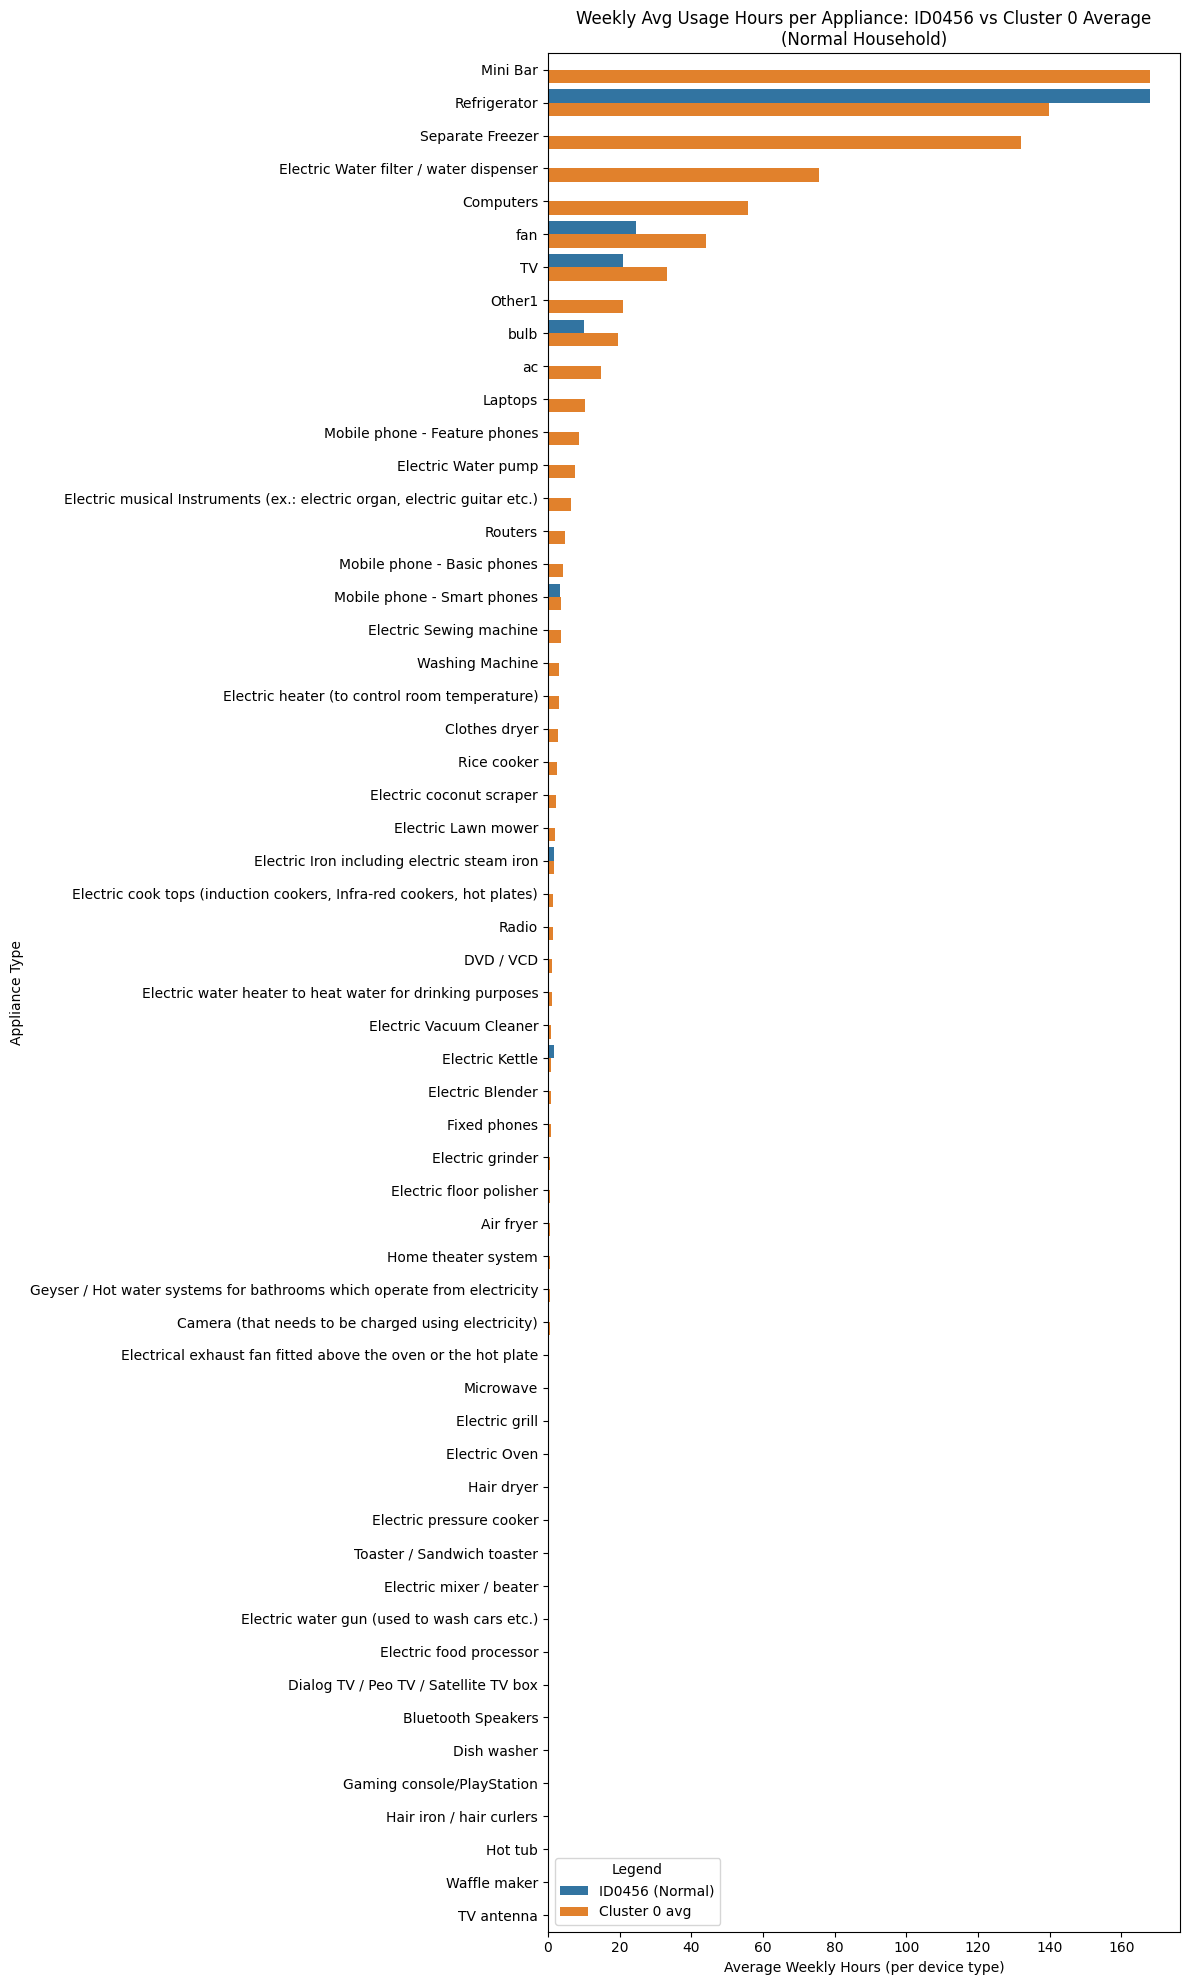


Detailed comparison for ID0456 (Cluster 0, Normal):


,appliance,household_hours,cluster_avg_hours
52,Mini Bar,NaN,168.000000
64,Refrigerator,168.000,139.897585
69,Separate Freezer,NaN,132.000000
21,Electric Water filter / water dispenser,NaN,75.571429
6,Computers,NaN,55.867647
77,fan,24.500,44.033552
71,TV,21.000,33.348903
58,Other1,NaN,21.000000
79,bulb,10.082,19.646345
78,ac,NaN,14.863611


In [23]:
# Example: Plot appliance usage for a specific household
# You can change this ID to any household in your dataset
target_household = 'ID0456'  # Change this to any household ID you want to analyze

if target_household in merged_app.index:
    plot_household_vs_cluster(target_household, merged_app)
else:
    # Find the first available household in each cluster for demonstration
    print(f'Household {target_household} not found. Showing examples from each cluster:')
    
    for cluster_id in sorted(merged_app['cluster'].unique()):
        cluster_households = merged_app[merged_app['cluster'] == cluster_id].index
        if len(cluster_households) > 0:
            example_hh = cluster_households[0]
            print(f'\n--- Example from Cluster {cluster_id} ---')
            plot_household_vs_cluster(example_hh, merged_app)
            break  # Just show one example to start

=== CLUSTER-WISE ANOMALY COMPARISON ===

Cluster 0 Analysis:
  Anomalous households: 42
  Normal households: 657


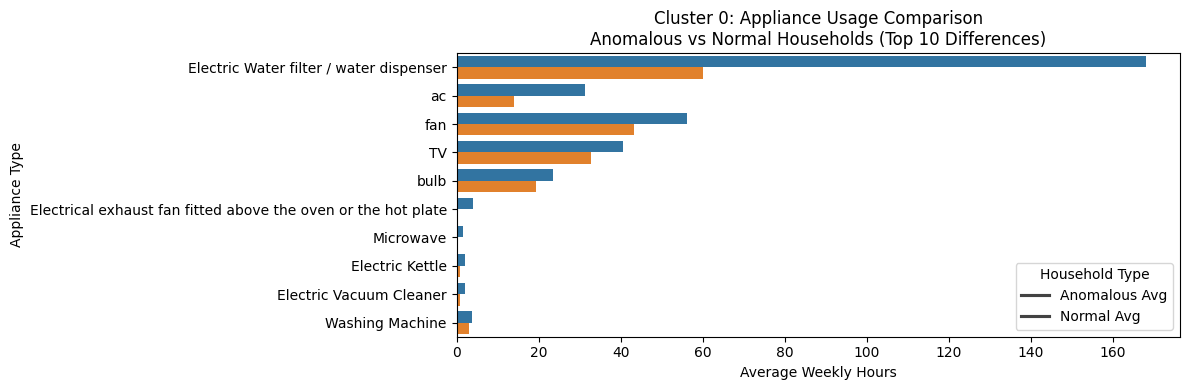


  Top appliance differences (Anomalous - Normal):


,appliance,anomalous_avg,normal_avg,difference
21,Electric Water filter / water dispenser,168.000000,60.166667,107.833333
78,ac,31.266667,14.000292,17.266374
77,fan,56.203333,43.250930,12.952404
71,TV,40.564516,32.907712,7.656804
79,bulb,23.523403,19.397739,4.125663
39,Electrical exhaust fan fitted above the oven o...,4.000000,0.157857,3.842143
51,Microwave,1.500000,0.328431,1.171569
16,Electric Kettle,1.964286,0.886712,1.077574
20,Electric Vacuum Cleaner,2.000000,0.926744,1.073256
76,Washing Machine,3.718095,3.128061,0.590035



Cluster 1 Analysis:
  Anomalous households: 27
  Normal households: 288


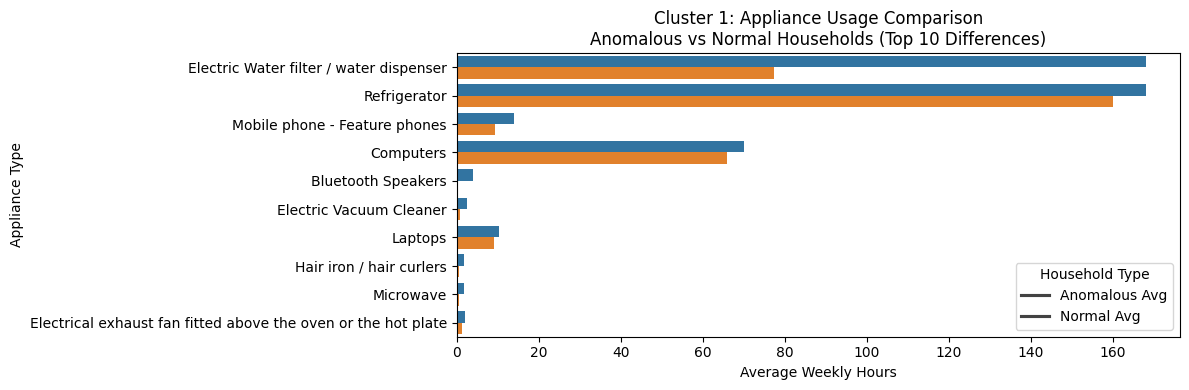


  Top appliance differences (Anomalous - Normal):


,appliance,anomalous_avg,normal_avg,difference
21,Electric Water filter / water dispenser,168.000000,77.410417,90.589583
64,Refrigerator,168.000000,160.076585,7.923415
54,Mobile phone - Feature phones,14.000000,9.416667,4.583333
6,Computers,70.000000,65.833333,4.166667
1,Bluetooth Speakers,4.000000,0.000000,4.000000
20,Electric Vacuum Cleaner,2.562500,0.920105,1.642395
50,Laptops,10.392045,9.094016,1.298030
46,Hair iron / hair curlers,1.750000,0.500000,1.250000
51,Microwave,1.745333,0.705463,1.039870
39,Electrical exhaust fan fitted above the oven o...,2.125000,1.340278,0.784722



Cluster 2 Analysis:
  Anomalous households: 71
  Normal households: 1088


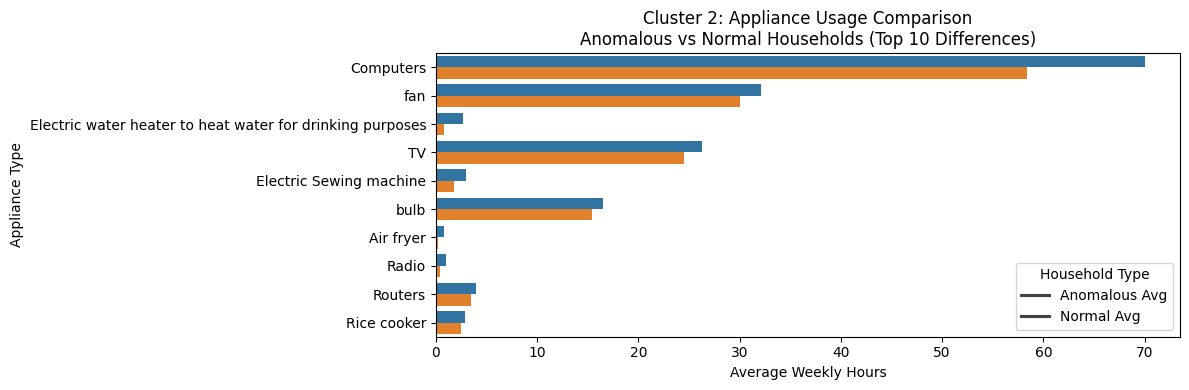


  Top appliance differences (Anomalous - Normal):


,appliance,anomalous_avg,normal_avg,difference
6,Computers,70.000000,58.396226,11.603774
77,fan,32.147904,30.035281,2.112622
38,Electric water heater to heat water for drinki...,2.680000,0.833950,1.846050
71,TV,26.268519,24.526106,1.742413
19,Electric Sewing machine,3.000000,1.816667,1.183333
79,bulb,16.486394,15.398853,1.087540
0,Air fryer,0.770750,0.160526,0.610224
63,Radio,1.000000,0.435897,0.564103
67,Routers,4.000000,3.509615,0.490385
65,Rice cooker,2.899074,2.473349,0.425725



Cluster 3 Analysis:
  Anomalous households: 17
  Normal households: 132


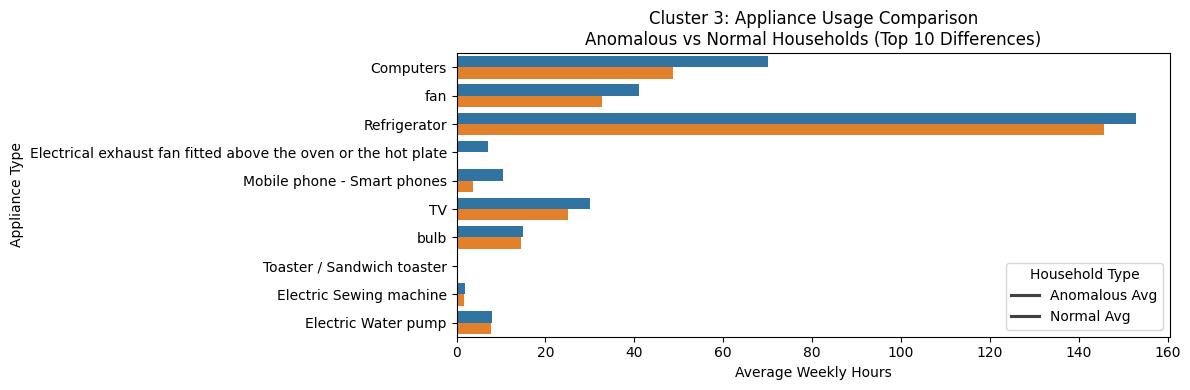


  Top appliance differences (Anomalous - Normal):


,appliance,anomalous_avg,normal_avg,difference
6,Computers,70.000000,48.785714,21.214286
77,fan,40.965686,32.798845,8.166841
64,Refrigerator,152.941176,145.743802,7.197375
39,Electrical exhaust fan fitted above the oven o...,7.000000,0.035714,6.964286
55,Mobile phone - Smart phones,10.500000,3.626389,6.873611
71,TV,29.923077,25.054513,4.868564
79,bulb,14.972836,14.516964,0.455872
73,Toaster / Sandwich toaster,0.431818,0.107000,0.324818
19,Electric Sewing machine,2.000000,1.736667,0.263333
22,Electric Water pump,8.000000,7.750000,0.250000


In [24]:
# Compare anomalous vs normal households within each cluster
def compare_cluster_anomalies(cluster_id, merged_data):
    """Compare appliance usage between anomalous and normal households within a cluster"""
    
    cluster_data = merged_data[merged_data['cluster'] == cluster_id]
    if cluster_data.empty:
        print(f'No data found for Cluster {cluster_id}')
        return
    
    anomalous_data = cluster_data[cluster_data['anomalous']]
    normal_data = cluster_data[~cluster_data['anomalous']]
    
    print(f'\nCluster {cluster_id} Analysis:')
    print(f'  Anomalous households: {len(anomalous_data)}')
    print(f'  Normal households: {len(normal_data)}')
    
    if len(anomalous_data) == 0 or len(normal_data) == 0:
        print(f'  Insufficient data for comparison (need both anomalous and normal households)')
        return
    
    hours_cols = [c for c in merged_data.columns if c.startswith('hours__')]
    if not hours_cols:
        print('  No appliance hours data available')
        return
    
    # Calculate means
    anomalous_means = anomalous_data[hours_cols].mean(numeric_only=True)
    normal_means = normal_data[hours_cols].mean(numeric_only=True)
    
    # Create comparison dataframe
    comp_df = pd.DataFrame({
        'appliance': [c.replace('hours__','') for c in hours_cols],
        'anomalous_avg': anomalous_means.values,
        'normal_avg': normal_means.values
    })
    
    # Remove appliances with no data
    comp_df = comp_df.dropna(how='all', subset=['anomalous_avg', 'normal_avg'])
    if comp_df.empty:
        print('  No appliance data available for comparison')
        return
    
    # Calculate difference
    comp_df['difference'] = comp_df['anomalous_avg'] - comp_df['normal_avg']
    comp_df = comp_df.sort_values('difference', ascending=False)
    
    # Plot top 10 appliances with biggest differences
    top_diff = comp_df.head(10)
    plot_df = top_diff.melt(id_vars='appliance', value_vars=['anomalous_avg', 'normal_avg'],
                           var_name='type', value_name='hours')
    
    plt.figure(figsize=(12, max(4, 0.4*len(top_diff))))
    sns.barplot(data=plot_df, y='appliance', x='hours', hue='type', orient='h')
    plt.title(f'Cluster {cluster_id}: Appliance Usage Comparison\nAnomalous vs Normal Households (Top 10 Differences)')
    plt.xlabel('Average Weekly Hours')
    plt.ylabel('Appliance Type')
    plt.legend(title='Household Type', labels=['Anomalous Avg', 'Normal Avg'])
    plt.tight_layout()
    plt.show()
    
    print(f'\n  Top appliance differences (Anomalous - Normal):')
    display(top_diff[['appliance', 'anomalous_avg', 'normal_avg', 'difference']].head(10))
    
    return comp_df

# Run comparison for each cluster with sufficient data
print('=== CLUSTER-WISE ANOMALY COMPARISON ===')
for cluster_id in sorted(merged_app['cluster'].unique()):
    compare_cluster_anomalies(cluster_id, merged_app)

=== APPLIANCE USAGE SUMMARY BY CLUSTER ===
   cluster_id     status  household_count  avg_total_weekly_hours  \
0           0  Anomalous               42              233.509792   
1           0     Normal              657              222.368333   
2           1  Anomalous               27              311.790947   
3           1     Normal              288              278.312672   
4           2  Anomalous               71              180.389593   
5           2     Normal             1088              194.455799   
6           3  Anomalous               17              257.410875   
7           3     Normal              132              226.649944   

   avg_appliance_types_used  
0                  8.952381  
1                  9.101979  
2                 16.925926  
3                 14.750000  
4                  8.985915  
5                  8.525735  
6                 11.529412  
7                 10.643939  

Summary saved to: cluster_appliance_usage_summary.csv


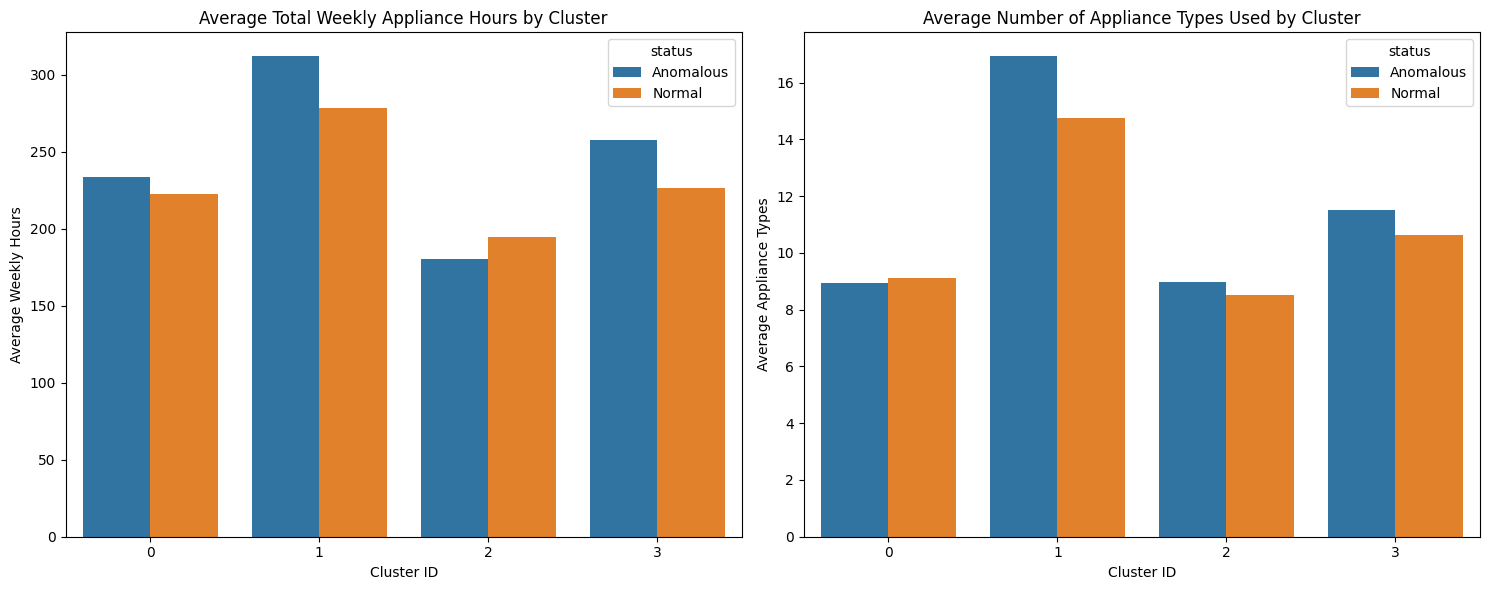

In [25]:
# Summary statistics of appliance usage by cluster and anomaly status
print('=== APPLIANCE USAGE SUMMARY BY CLUSTER ===')

hours_cols = [c for c in merged_app.columns if c.startswith('hours__')]
if not hours_cols:
    print('No appliance hours data available for summary')
else:
    # Calculate summary statistics
    summary_data = []
    
    for cluster_id in sorted(merged_app['cluster'].unique()):
        cluster_data = merged_app[merged_app['cluster'] == cluster_id]
        
        for is_anomalous in [True, False]:
            subset = cluster_data[cluster_data['anomalous'] == is_anomalous]
            status = 'Anomalous' if is_anomalous else 'Normal'
            
            if len(subset) > 0:
                # Calculate total weekly appliance hours per household
                total_hours = subset[hours_cols].sum(axis=1, skipna=True)
                avg_total_hours = total_hours.mean()
                
                # Count of different appliances used
                appliance_counts = subset[hours_cols].notna().sum(axis=1)
                avg_appliance_count = appliance_counts.mean()
                
                summary_data.append({
                    'cluster_id': cluster_id,
                    'status': status,
                    'household_count': len(subset),
                    'avg_total_weekly_hours': avg_total_hours,
                    'avg_appliance_types_used': avg_appliance_count
                })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Display summary
    print(summary_df)
    
    # Save summary
    summary_df.to_csv('cluster_appliance_usage_summary.csv', index=False)
    print('\nSummary saved to: cluster_appliance_usage_summary.csv')
    
    # Plot summary
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Average total weekly hours
    sns.barplot(data=summary_df, x='cluster_id', y='avg_total_weekly_hours', hue='status', ax=ax1)
    ax1.set_title('Average Total Weekly Appliance Hours by Cluster')
    ax1.set_xlabel('Cluster ID')
    ax1.set_ylabel('Average Weekly Hours')
    
    # Plot 2: Average appliance types used
    sns.barplot(data=summary_df, x='cluster_id', y='avg_appliance_types_used', hue='status', ax=ax2)
    ax2.set_title('Average Number of Appliance Types Used by Cluster')
    ax2.set_xlabel('Cluster ID')
    ax2.set_ylabel('Average Appliance Types')
    
    plt.tight_layout()
    plt.show()

## Find Anomalous Households with Similar Appliance Usage Patterns

This section identifies anomalous households that have similar appliance usage patterns
to normal households within the same cluster. This helps identify households that
may be anomalous in their consumption but have typical appliance usage behaviors.

In [26]:
# Find anomalous households with similar appliance usage behavior (only selected appliances)
import numpy as np
import pandas as pd

# Appliances of interest
target_appliances = [
    "TV",
    "ac",
    "Washing Machine",
    "fan",
    "Geyser / Hot water systems for bathrooms which operate from electricity",
    "Electric Water pump"
]

# Map to hours__* column names
target_cols = [f"hours__{a}" for a in target_appliances]

# Keep only the subset of appliances that exist in merged_app
hours_cols_subset = [col for col in target_cols if col in merged_app.columns]

print("Appliances being considered:", [col.replace("hours__","") for col in hours_cols_subset])
print(f"Found {len(hours_cols_subset)} out of {len(target_appliances)} target appliances in the data")

Appliances being considered: ['TV', 'ac', 'Washing Machine', 'fan', 'Geyser / Hot water systems for bathrooms which operate from electricity', 'Electric Water pump']
Found 6 out of 6 target appliances in the data


In [27]:
# Function to check if household usage is within k standard deviations of normals
def within_std_deviation_cluster(household_data, normal_means, normal_stds, hours_cols, k=1):
    """Check if household appliance usage is within k standard deviations of cluster normal households"""
    checks = []
    for col in hours_cols:
        if pd.notna(household_data[col]) and pd.notna(normal_means[col]) and pd.notna(normal_stds[col]):
            diff = abs(household_data[col] - normal_means[col])
            checks.append(diff <= k * normal_stds[col])
    return checks if checks else [False]  # if no valid appliances, return False

# Configurable parameter: how many standard deviations to allow
K_STD_CLUSTER = 1   # try 1, 1.5, or 2

similar_behavior_households_cluster = []

print(f"=== FINDING SIMILAR APPLIANCE USAGE PATTERNS (within {K_STD_CLUSTER} std dev) ===")

=== FINDING SIMILAR APPLIANCE USAGE PATTERNS (within 1 std dev) ===


In [28]:
# Process each cluster
for cluster_id in sorted(merged_app['cluster'].unique()):
    print(f"\n--- Processing Cluster {cluster_id} ---")
    
    # Get normal households for this cluster
    normal_mask = (merged_app['cluster'] == cluster_id) & (~merged_app['anomalous'])
    normal_subset = merged_app[normal_mask][hours_cols_subset]
    
    # Skip cluster if no target appliances exist in this group
    available_cols = [c for c in hours_cols_subset if normal_subset[c].notna().any()]
    if not available_cols:
        print(f"  Skipping Cluster {cluster_id}: none of the target appliances available.")
        continue
    
    print(f"  Available appliances in Cluster {cluster_id}: {[c.replace('hours__','') for c in available_cols]}")
    
    normal_means = normal_subset[available_cols].mean()
    normal_stds = normal_subset[available_cols].std()
    
    # Get anomalous households for this cluster
    anomalous_mask = (merged_app['cluster'] == cluster_id) & (merged_app['anomalous'])
    anomalous_households = merged_app[anomalous_mask]
    
    print(f"  Normal households in Cluster {cluster_id}: {normal_mask.sum()}")
    print(f"  Anomalous households in Cluster {cluster_id}: {anomalous_mask.sum()}")
    
    if anomalous_mask.sum() == 0:
        print(f"  No anomalous households found in Cluster {cluster_id}")
        continue
    
    # Check each anomalous household
    cluster_similar_count = 0
    for idx, household in anomalous_households.iterrows():
        checks = within_std_deviation_cluster(household, normal_means, normal_stds, available_cols, k=K_STD_CLUSTER)
        # If ALL appliances are within k std devs → similar
        if all(checks):
            cluster_similar_count += 1
            similar_behavior_households_cluster.append({
                'household_ID': idx,
                'cluster_id': cluster_id,
                'num_appliances_compared': len(checks),
                'appliances_compared': [c.replace("hours__","") for c in available_cols],
                'k_std_used': K_STD_CLUSTER,
                'normal_households_in_cluster': normal_mask.sum(),
                'total_anomalous_in_cluster': anomalous_mask.sum()
            })
    
    print(f"  Anomalous households with similar patterns: {cluster_similar_count}")

print(f"\n=== CLUSTER ANALYSIS COMPLETED ===")


--- Processing Cluster 0 ---
  Available appliances in Cluster 0: ['TV', 'ac', 'Washing Machine', 'fan', 'Geyser / Hot water systems for bathrooms which operate from electricity', 'Electric Water pump']
  Normal households in Cluster 0: 657
  Anomalous households in Cluster 0: 42
  Anomalous households with similar patterns: 16

--- Processing Cluster 1 ---
  Available appliances in Cluster 1: ['TV', 'ac', 'Washing Machine', 'fan', 'Geyser / Hot water systems for bathrooms which operate from electricity', 'Electric Water pump']
  Normal households in Cluster 1: 288
  Anomalous households in Cluster 1: 27
  Anomalous households with similar patterns: 13

--- Processing Cluster 2 ---
  Available appliances in Cluster 2: ['TV', 'ac', 'Washing Machine', 'fan', 'Electric Water pump']
  Normal households in Cluster 2: 1088
  Anomalous households in Cluster 2: 71
  Anomalous households with similar patterns: 39

--- Processing Cluster 3 ---
  Available appliances in Cluster 3: ['TV', 'ac', '

In [29]:
# Create DataFrame of similar behavior households
similar_cluster_df = pd.DataFrame(similar_behavior_households_cluster)

# Save results
if not similar_cluster_df.empty:
    similar_cluster_df.to_csv('anomalous_households_similar_selected_appliances_by_cluster.csv', index=False)
    
    # Show summary by cluster
    print('\nAnomalous households with similar appliance usage behavior (selected appliances only):')
    print(f'Using {K_STD_CLUSTER} standard deviation threshold')
    cluster_summary = similar_cluster_df.groupby('cluster_id').agg({
        'household_ID': 'count',
        'total_anomalous_in_cluster': 'first',
        'normal_households_in_cluster': 'first'
    }).rename(columns={'household_ID': 'similar_households'})
    
    cluster_summary['percentage_of_anomalous'] = (cluster_summary['similar_households'] / 
                                                 cluster_summary['total_anomalous_in_cluster'] * 100).round(1)
    
    print('\nSummary by Cluster:')
    print(cluster_summary)
    
    print('\nDetailed results:')
    display(similar_cluster_df[['household_ID', 'cluster_id', 'num_appliances_compared', 'appliances_compared']])
else:
    print(f'No anomalous households found with similar appliance usage behavior (selected appliances only)')
    print(f'Using {K_STD_CLUSTER} standard deviation threshold')


Anomalous households with similar appliance usage behavior (selected appliances only):
Using 1 standard deviation threshold

Summary by Cluster:
            similar_households  total_anomalous_in_cluster  \
cluster_id                                                   
0                           16                          42   
1                           13                          27   
2                           39                          71   
3                            9                          17   

            normal_households_in_cluster  percentage_of_anomalous  
cluster_id                                                         
0                                    657                     38.1  
1                                    288                     48.1  
2                                   1088                     54.9  
3                                    132                     52.9  

Detailed results:


,household_ID,cluster_id,num_appliances_compared,appliances_compared
0,ID0327,0,3,"[TV, ac, Washing Machine, fan, Geyser / Hot wa..."
1,ID0429,0,2,"[TV, ac, Washing Machine, fan, Geyser / Hot wa..."
2,ID0490,0,1,"[TV, ac, Washing Machine, fan, Geyser / Hot wa..."
3,ID0596,0,2,"[TV, ac, Washing Machine, fan, Geyser / Hot wa..."
4,ID0851,0,1,"[TV, ac, Washing Machine, fan, Geyser / Hot wa..."
...,...,...,...,...
72,ID1810,3,4,"[TV, ac, Washing Machine, fan, Geyser / Hot wa..."
73,ID1815,3,2,"[TV, ac, Washing Machine, fan, Geyser / Hot wa..."
74,ID1914,3,4,"[TV, ac, Washing Machine, fan, Geyser / Hot wa..."
75,ID1953,3,3,"[TV, ac, Washing Machine, fan, Geyser / Hot wa..."


In [30]:
# Detailed analysis - show appliance usage comparison for examples from each cluster
if not similar_cluster_df.empty:
    print('=== DETAILED APPLIANCE USAGE COMPARISONS ===')
    
    # Show one example from each cluster
    for cluster_id in sorted(similar_cluster_df['cluster_id'].unique()):
        cluster_examples = similar_cluster_df[similar_cluster_df['cluster_id'] == cluster_id]
        if len(cluster_examples) > 0:
            example_hh = cluster_examples['household_ID'].iloc[0]
            
            print(f'\n--- Cluster {cluster_id} Example: Household {example_hh} ---')
            
            # Get normal averages and stds for this cluster
            normal_mask = (merged_app['cluster'] == cluster_id) & (~merged_app['anomalous'])
            normal_means = merged_app[normal_mask][hours_cols_subset].mean()
            normal_stds = merged_app[normal_mask][hours_cols_subset].std()
            
            # Get household data
            hh_data = merged_app.loc[example_hh][hours_cols_subset]
            
            # Create comparison DataFrame
            comparison = pd.DataFrame({
                'appliance': [col.replace('hours__','') for col in hours_cols_subset],
                'household_hours': hh_data.values,
                'cluster_normal_average': normal_means.values,
                'cluster_normal_std': normal_stds.values
            })
            
            # Only show appliances present in both normal group and household
            comparison = comparison.dropna(subset=['household_hours','cluster_normal_average','cluster_normal_std'])
            
            if not comparison.empty:
                comparison['within_k_std'] = (abs(comparison['household_hours'] - comparison['cluster_normal_average']) 
                                             <= K_STD_CLUSTER * comparison['cluster_normal_std'])
                comparison['std_dev_difference'] = (abs(comparison['household_hours'] - comparison['cluster_normal_average']) 
                                                   / comparison['cluster_normal_std']).round(2)
                
                print(f'Appliances compared: {len(comparison)}')
                print(f'All within {K_STD_CLUSTER} std dev: {comparison["within_k_std"].all()}')
                display(comparison)
            else:
                print('No comparable appliances found for this household.')
else:
    print('No examples to show - no similar households found.')

=== DETAILED APPLIANCE USAGE COMPARISONS ===

--- Cluster 0 Example: Household ID0327 ---
Appliances compared: 3
All within 1 std dev: True


,appliance,household_hours,cluster_normal_average,cluster_normal_std,within_k_std,std_dev_difference
0,TV,14.0,32.907712,23.946973,True,0.789566
2,Washing Machine,5.25,3.128061,3.071562,True,0.690834
3,fan,32.55,43.250930,29.496992,True,0.36278



--- Cluster 1 Example: Household ID0613 ---
Appliances compared: 4
All within 1 std dev: True


,appliance,household_hours,cluster_normal_average,cluster_normal_std,within_k_std,std_dev_difference
0,TV,35.0,25.893408,22.031976,True,0.413335
1,ac,5.0,20.130861,23.848145,True,0.634467
2,Washing Machine,4.0,3.200843,2.842167,True,0.281179
3,fan,21.0625,30.833777,22.074986,True,0.44264



--- Cluster 2 Example: Household ID0043 ---
Appliances compared: 4
All within 1 std dev: True


,appliance,household_hours,cluster_normal_average,cluster_normal_std,within_k_std,std_dev_difference
0,TV,21.0,24.526106,19.987813,True,0.176413
1,ac,36.75,16.456022,25.651484,True,0.791142
2,Washing Machine,1.175,1.990168,2.544493,True,0.320366
3,fan,7.0,30.035281,27.377889,True,0.841383



--- Cluster 3 Example: Household ID0052 ---
Appliances compared: 1
All within 1 std dev: True


,appliance,household_hours,cluster_normal_average,cluster_normal_std,within_k_std,std_dev_difference
3,fan,31.25,32.798845,24.648837,True,0.062836


=== VISUALIZATION: SIMILAR vs NON-SIMILAR ANOMALOUS HOUSEHOLDS ===


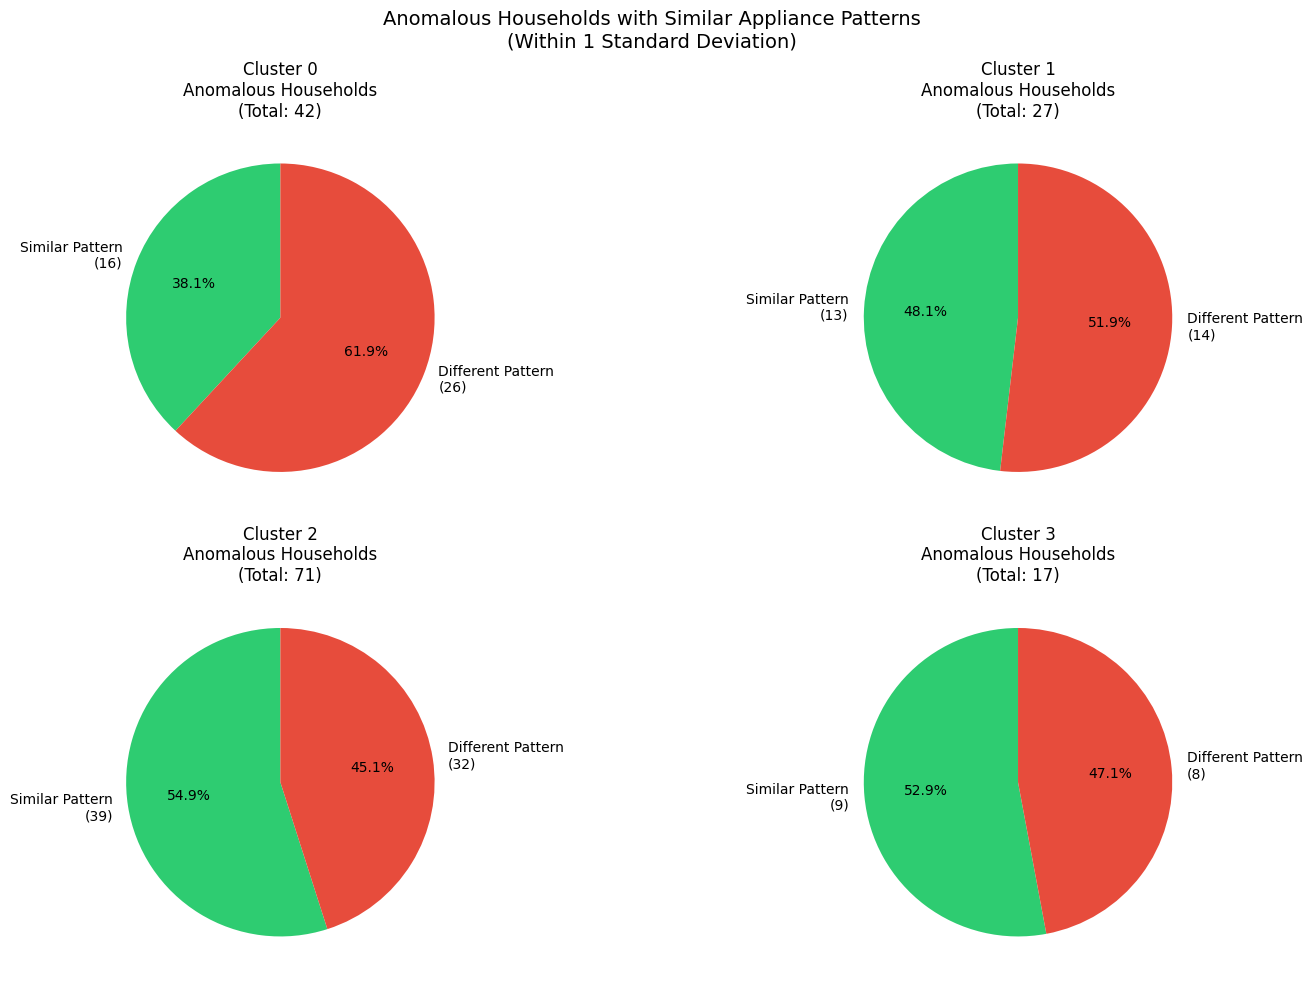

In [31]:
# Visualization: Compare similar vs non-similar anomalous households
if not similar_cluster_df.empty:
    print('=== VISUALIZATION: SIMILAR vs NON-SIMILAR ANOMALOUS HOUSEHOLDS ===')
    
    # Create comparison by cluster
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, cluster_id in enumerate(sorted(merged_app['cluster'].unique())):
        if i >= 4:  # Only show first 4 clusters
            break
            
        # Get data for this cluster
        cluster_data = merged_app[merged_app['cluster'] == cluster_id]
        anomalous_data = cluster_data[cluster_data['anomalous']]
        
        if len(anomalous_data) == 0:
            axes[i].text(0.5, 0.5, f'No anomalous\nhouseholds\nin Cluster {cluster_id}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'Cluster {cluster_id}')
            continue
        
        # Identify similar vs non-similar households
        similar_hh_ids = set(similar_cluster_df[similar_cluster_df['cluster_id'] == cluster_id]['household_ID'])
        
        similar_count = len(similar_hh_ids.intersection(set(anomalous_data.index)))
        non_similar_count = len(anomalous_data) - similar_count
        
        # Create pie chart
        if similar_count > 0 or non_similar_count > 0:
            labels = []
            sizes = []
            colors = []
            
            if similar_count > 0:
                labels.append(f'Similar Pattern\n({similar_count})')
                sizes.append(similar_count)
                colors.append('#2ecc71')  # Green
            
            if non_similar_count > 0:
                labels.append(f'Different Pattern\n({non_similar_count})')
                sizes.append(non_similar_count)
                colors.append('#e74c3c')  # Red
            
            axes[i].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        
        axes[i].set_title(f'Cluster {cluster_id}\nAnomalous Households\n(Total: {len(anomalous_data)})')
    
    # Hide empty subplots
    for j in range(i+1, 4):
        axes[j].set_visible(False)
    
    plt.suptitle(f'Anomalous Households with Similar Appliance Patterns\n(Within {K_STD_CLUSTER} Standard Deviation)', 
                fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print('No visualization possible - no similar households found.')

In [32]:
# Summary statistics and insights
print('=== FINAL SUMMARY AND INSIGHTS ===')

if not similar_cluster_df.empty:
    total_similar = len(similar_cluster_df)
    total_anomalous = merged_app['anomalous'].sum()
    
    print(f'Total anomalous households analyzed: {total_anomalous}')
    print(f'Anomalous households with similar appliance patterns: {total_similar}')
    print(f'Percentage with similar patterns: {(total_similar/total_anomalous*100):.1f}%')
    
    print(f'\nUsing criteria: All target appliances within {K_STD_CLUSTER} standard deviation of cluster normal average')
    print(f'Target appliances: {", ".join([col.replace("hours__","") for col in hours_cols_subset])}')
    
    # Cluster-wise breakdown
    print('\nCluster-wise breakdown:')
    for cluster_id in sorted(merged_app['cluster'].unique()):
        cluster_anomalous = merged_app[(merged_app['cluster'] == cluster_id) & (merged_app['anomalous'])].shape[0]
        cluster_similar = similar_cluster_df[similar_cluster_df['cluster_id'] == cluster_id].shape[0]
        
        if cluster_anomalous > 0:
            percentage = (cluster_similar / cluster_anomalous * 100)
            print(f'  Cluster {cluster_id}: {cluster_similar}/{cluster_anomalous} ({percentage:.1f}%) anomalous households have similar patterns')
        else:
            print(f'  Cluster {cluster_id}: No anomalous households')
    
    print(f'\nResults saved to: anomalous_households_similar_selected_appliances_by_cluster.csv')
    
    # Insights
    print('\n=== INSIGHTS ===')
    print('• Households identified here are anomalous in their CONSUMPTION patterns but have')
    print('  NORMAL appliance usage patterns compared to their cluster peers')
    print('• This suggests their anomalous consumption may be due to:')
    print('  - Different usage timing/schedules')
    print('  - Appliance efficiency differences')
    print('  - Other electrical loads not captured in appliance survey')
    print('  - Measurement or reporting inconsistencies')
else:
    print(f'No anomalous households found with similar appliance usage patterns.')
    print(f'This could mean:')
    print(f'• The {K_STD_CLUSTER} standard deviation threshold is too strict')
    print(f'• Anomalous households truly have different appliance usage patterns')
    print(f'• Limited appliance data availability')
    print(f'\nTry adjusting K_STD_CLUSTER to 1.5 or 2 for more lenient matching.')

=== FINAL SUMMARY AND INSIGHTS ===
Total anomalous households analyzed: 157
Anomalous households with similar appliance patterns: 77
Percentage with similar patterns: 49.0%

Using criteria: All target appliances within 1 standard deviation of cluster normal average
Target appliances: TV, ac, Washing Machine, fan, Geyser / Hot water systems for bathrooms which operate from electricity, Electric Water pump

Cluster-wise breakdown:
  Cluster 0: 16/42 (38.1%) anomalous households have similar patterns
  Cluster 1: 13/27 (48.1%) anomalous households have similar patterns
  Cluster 2: 39/71 (54.9%) anomalous households have similar patterns
  Cluster 3: 9/17 (52.9%) anomalous households have similar patterns

Results saved to: anomalous_households_similar_selected_appliances_by_cluster.csv

=== INSIGHTS ===
• Households identified here are anomalous in their CONSUMPTION patterns but have
  NORMAL appliance usage patterns compared to their cluster peers
• This suggests their anomalous consump

## Built Year Analysis by Cluster

Analyze the distribution of house built years for households with similar appliance usage patterns
within each cluster to understand housing characteristics.

In [33]:
# Built Year Analysis for Similar Households by Cluster
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Check if we have similar households data
if similar_cluster_df.empty:
    print('No similar households found. Please run the previous analysis first.')
else:
    # Load household info
    info_path = Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_household_information_and_history.csv')
    if not info_path.exists():
        print('Household info file missing. Trying alternative path...')
        info_path = Path('wave_1/w1_household_information_and_history.csv')
    
    if info_path.exists():
        house_info = pd.read_csv(info_path)
        
        # Merge with similar households
        similar_info_cluster = pd.merge(
            similar_cluster_df,
            house_info[['household_ID', 'built_year_of_the_house']],
            on='household_ID',
            how='left'
        )
        
        print(f'Merged {len(similar_info_cluster)} similar households with house info')
    else:
        print('Could not find household information file.')

Merged 77 similar households with house info


In [34]:
# Recode built_year_of_the_house for cluster analysis
if 'similar_info_cluster' in locals():
    def recategorize_year_cluster(x):
        if pd.isna(x):
            return 'Old / Unknown'
        x = str(x).strip()
        if x.lower() == "don't know" or 'Before 1980' in x or '1980-1989' in x:
            return 'Old / Unknown'
        elif '1990-1999' in x or '2000-2009' in x:
            return 'Middle'
        elif '2010' in x or '2010-2019' in x or '2020' in x:
            return 'Recent'
        else:
            return 'Old / Unknown'
    
    similar_info_cluster['built_year_cat'] = similar_info_cluster['built_year_of_the_house'].apply(recategorize_year_cluster)
    
    # Fix category order
    cat_order = ['Old / Unknown', 'Middle', 'Recent']
    similar_info_cluster['built_year_cat'] = pd.Categorical(
        similar_info_cluster['built_year_cat'], 
        categories=cat_order, 
        ordered=True
    )
    
    # Count per Cluster + built year category
    counts_cluster = (
        similar_info_cluster
        .groupby(['cluster_id', 'built_year_cat'])
        .size()
        .reset_index(name='count')
    )
    
    # Compute percentages within each cluster
    counts_cluster['percentage'] = (
        counts_cluster.groupby('cluster_id')['count']
        .transform(lambda x: 100 * x / x.sum())
    )
    
    print('Built year distribution by cluster:')
    print(counts_cluster)

Built year distribution by cluster:
    cluster_id built_year_cat  count  percentage
0            0  Old / Unknown      3   18.750000
1            0         Middle      8   50.000000
2            0         Recent      5   31.250000
3            1  Old / Unknown      3   23.076923
4            1         Middle      5   38.461538
5            1         Recent      5   38.461538
6            2  Old / Unknown     23   58.974359
7            2         Middle     12   30.769231
8            2         Recent      4   10.256410
9            3  Old / Unknown      3   33.333333
10           3         Middle      2   22.222222
11           3         Recent      4   44.444444


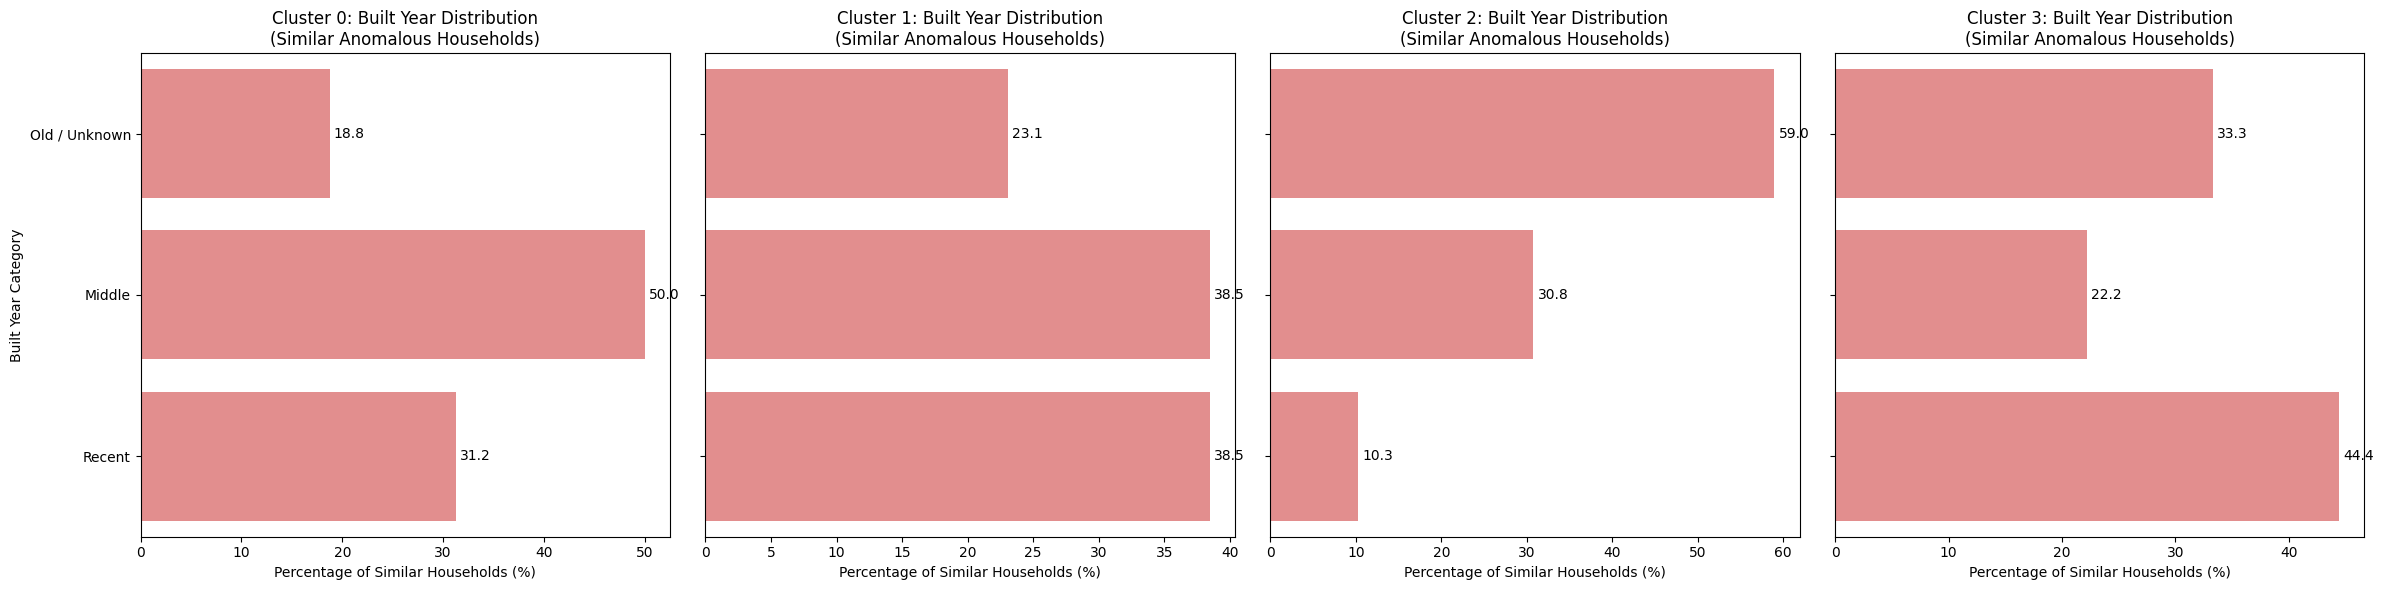


Saved -> built_year_distribution_similar_anomalous_households_by_cluster.csv


In [35]:
# Plot horizontal barplots side by side for clusters
if 'counts_cluster' in locals():
    clusters = sorted(counts_cluster['cluster_id'].unique())
    n_clusters = len(clusters)
    
    fig, axes = plt.subplots(1, n_clusters, figsize=(6*n_clusters, 6), sharey=True)
    
    if n_clusters == 1:
        axes = [axes]  # ensure iterable
    
    for ax, cluster in zip(axes, clusters):
        subset = counts_cluster[counts_cluster['cluster_id'] == cluster]
        sns.barplot(
            data=subset,
            x='percentage',
            y='built_year_cat',
            order=cat_order,  # enforce fixed order
            color='lightcoral',
            ax=ax
        )
        ax.set_title(f"Cluster {cluster}: Built Year Distribution\n(Similar Anomalous Households)")
        ax.set_xlabel("Percentage of Similar Households (%)")
        ax.set_ylabel("Built Year Category")
        
        # Add value labels at end of bars
        for container in ax.containers:
            ax.bar_label(container, fmt="%.1f", label_type="edge", padding=3)
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    counts_cluster.to_csv('built_year_distribution_similar_anomalous_households_by_cluster.csv', index=False)
    print('\nSaved -> built_year_distribution_similar_anomalous_households_by_cluster.csv')
else:
    print('No built year data available for analysis.')

## Appliance Age Analysis by Cluster

Analyze the age distribution of appliances for households with similar usage patterns
within each cluster to understand appliance replacement patterns.

In [36]:
# Load appliance specifications for age analysis
AGE_FILE_CANDIDATES = [
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv'),
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_appliance_specifications.csv'),
    Path('wave_1/household_appliance_specifications_202509020921.csv'),
    Path('wave_1/w1_appliance_specifications.csv')
]

spec_df = None
for age_file in AGE_FILE_CANDIDATES:
    if age_file.exists():
        try:
            spec_df = pd.read_csv(age_file, low_memory=False)
            print(f'Loaded appliance specifications from: {age_file}')
            break
        except Exception as e:
            print(f'Error loading {age_file}: {e}')
            continue

if spec_df is None:
    print('Could not find appliance specifications file. Skipping appliance age analysis.')
else:
    # Standardize column names
    spec_df.columns = [c.strip().lower().replace(' ', '_') for c in spec_df.columns]
    
    # Identify columns
    hh_col_age = next(c for c in spec_df.columns if 'household' in c and 'id' in c)
    appliance_col = next(c for c in spec_df.columns if 'appliance' in c and ('name' in c or c.endswith('appliance')))
    
    print(f'Using columns: HH={hh_col_age}, Appliance={appliance_col}')
    print(f'Appliance specifications data shape: {spec_df.shape}')

Loaded appliance specifications from: /home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv
Using columns: HH=household_id, Appliance=appliance_name
Appliance specifications data shape: (35315, 27)


In [37]:
# Process appliance age data
if spec_df is not None:
    # Collapse purchase_time columns into one
    age_cols = sorted([c for c in spec_df.columns if c.startswith('purchased_time')],
                      key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))
    
    print(f'Found age columns: {age_cols}')
    
    def pick_age_cluster(row):
        for c in age_cols:
            val = str(row[c]).strip()
            if pd.notna(row[c]) and val != '' and val.lower() not in ['nan']:
                return val
        return 'Unknown'
    
    spec_df['appliance_age'] = spec_df.apply(pick_age_cluster, axis=1)
    age_long = spec_df[[hh_col_age, appliance_col, 'appliance_age']].copy()
    
    # Filter to households identified as similar anomalous usage
    if not similar_cluster_df.empty:
        age_similar_cluster = age_long.merge(
            similar_cluster_df[['household_ID', 'cluster_id']], 
            left_on=hh_col_age, 
            right_on='household_ID', 
            how='inner'
        )
        
        print(f'Merged appliance age data: {len(age_similar_cluster)} records')
        print(f'Unique appliances: {age_similar_cluster[appliance_col].nunique()}')
    else:
        print('No similar households to analyze.')

Found age columns: ['purchased_time1', 'purchased_time2', 'purchased_time3', 'purchased_time4']
Merged appliance age data: 635 records
Unique appliances: 46


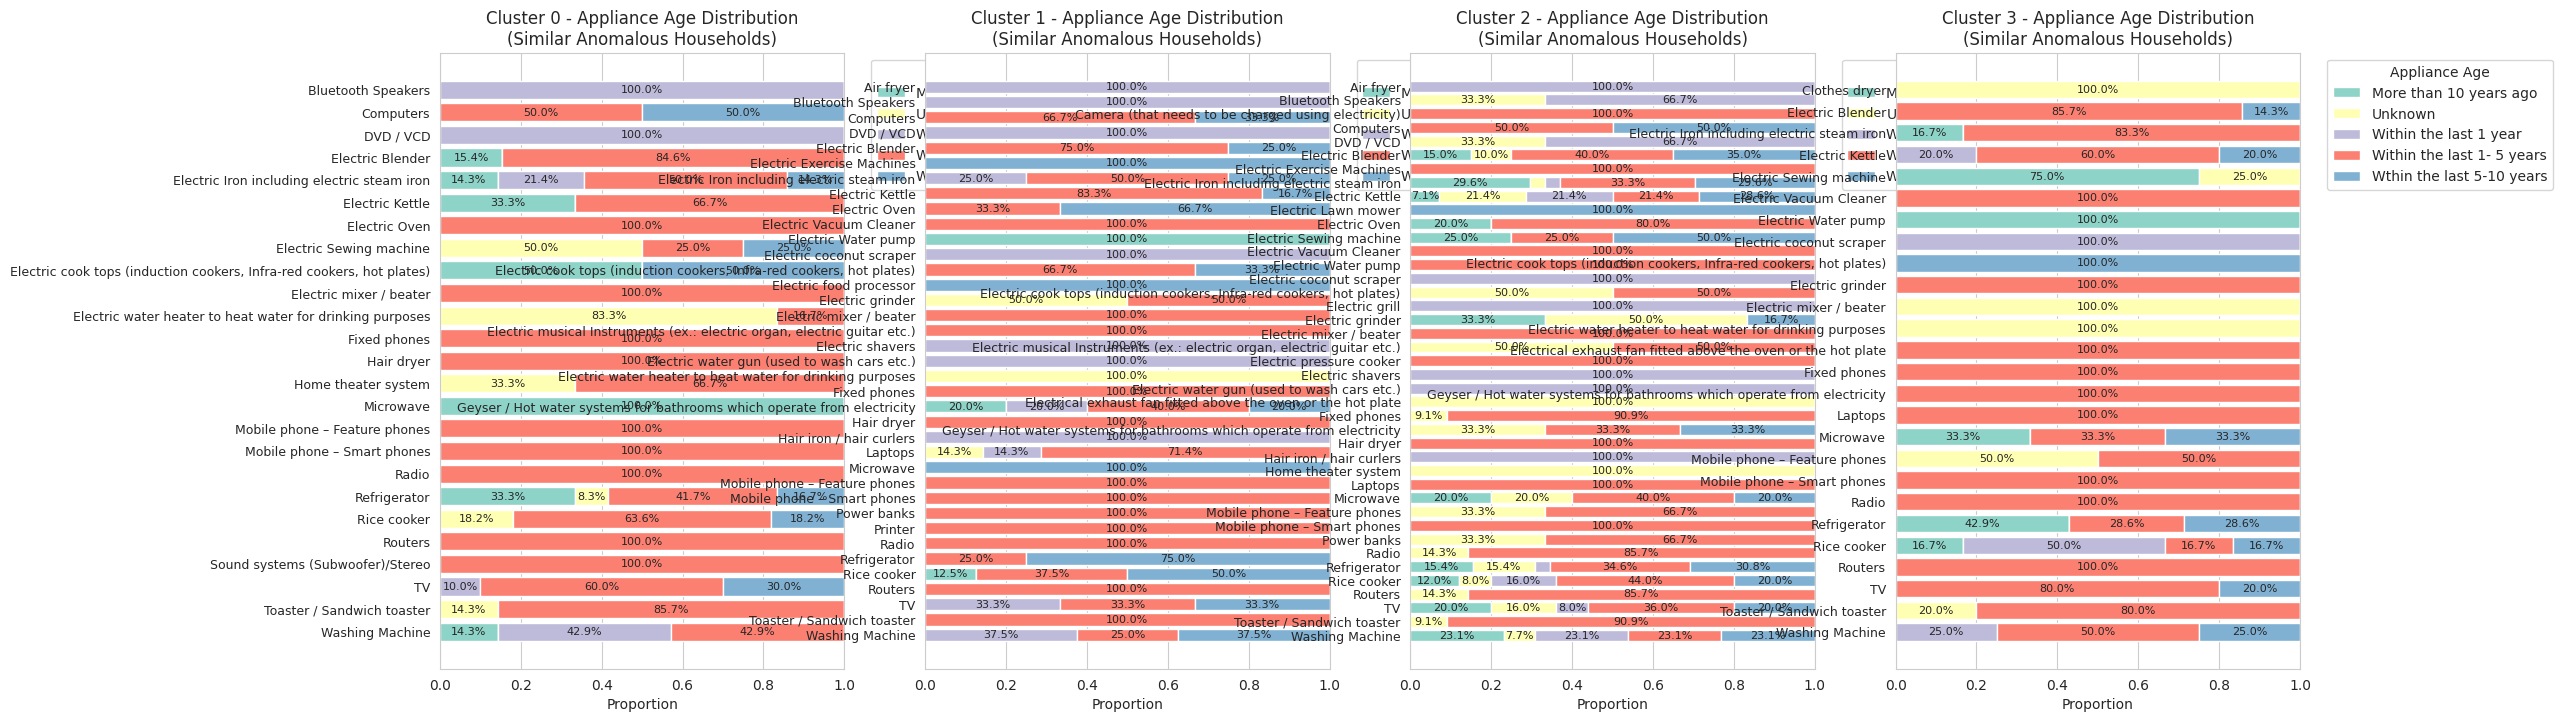


Saved -> appliance_age_distribution_similar_anomalous_households_by_cluster.csv


In [38]:
# Compute appliance age proportions per cluster
if 'age_similar_cluster' in locals():
    # Compute proportions per cluster and appliance
    dist_cluster = (
        age_similar_cluster.groupby(['cluster_id', appliance_col, 'appliance_age'])[appliance_col]
        .count()
        .rename('count')
        .reset_index()
    )
    dist_cluster['proportion'] = dist_cluster.groupby(['cluster_id', appliance_col])['count'].transform(lambda s: s / s.sum())
    
    # Plot horizontal stacked bars per cluster
    cluster_ids = sorted(dist_cluster['cluster_id'].unique())
    n_clusters = len(cluster_ids)
    
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, n_clusters, figsize=(6*n_clusters, 8), sharey=False)
    if n_clusters == 1:
        axes = [axes]
    
    for ax, cluster_id in zip(axes, cluster_ids):
        cluster_data = dist_cluster[dist_cluster['cluster_id']==cluster_id].copy()
        appliances = cluster_data[appliance_col].unique()
        y_positions = np.arange(len(appliances))
        bottom_vals = np.zeros(len(appliances))
        
        colors = sns.color_palette("Set3", dist_cluster['appliance_age'].nunique())
        
        for i, age_cat in enumerate(sorted(cluster_data['appliance_age'].unique())):
            subset = cluster_data[cluster_data['appliance_age']==age_cat].set_index(appliance_col)
            vals = [subset['proportion'].get(appl,0) for appl in appliances]
            bars = ax.barh(y_positions, vals, left=bottom_vals, label=age_cat, color=colors[i])
            bottom_vals += vals
            
            # Add percentages
            for bar, val in zip(bars, vals):
                if val > 0.05:  # Only show labels for segments > 5%
                    ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2,
                            f'{val*100:.1f}%', ha='center', va='center', fontsize=8)
        
        ax.set_yticks(y_positions)
        ax.set_yticklabels(appliances, fontsize=9)
        ax.set_xlabel('Proportion')
        ax.set_title(f'Cluster {cluster_id} - Appliance Age Distribution\n(Similar Anomalous Households)')
        ax.invert_yaxis()
        ax.legend(title='Appliance Age', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Save table
    dist_cluster.to_csv('appliance_age_distribution_similar_anomalous_households_by_cluster.csv', index=False)
    print('\nSaved -> appliance_age_distribution_similar_anomalous_households_by_cluster.csv')
else:
    print('No appliance age data available for analysis.')

## Household-Level Appliance Age Mode by Cluster

Analyze the most common appliance age category for each household within clusters
to understand overall household appliance replacement patterns.

In [39]:
# Focus on target appliances and compute household-level mode
if 'age_similar_cluster' in locals():
    # Keep only target appliances
    target_appliances_age = [
        "TV",
        "Air Conditioner",
        "Washing Machine",
        "Fan",
        "Geyser / Hot water systems for bathrooms which operate from electricity",
        "Electric Water pump"
    ]
    
    age_subset_cluster = age_similar_cluster[
        age_similar_cluster[appliance_col].isin(target_appliances_age)
    ].copy()
    
    print(f'Filtered to target appliances: {len(age_subset_cluster)} records')
    print(f'Target appliances found: {age_subset_cluster[appliance_col].unique()}')
    
    # Compute household-level mode of appliance age
    household_mode_age_cluster = (
        age_subset_cluster.groupby([hh_col_age, 'cluster_id'])['appliance_age']
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
        .reset_index()
        .rename(columns={'appliance_age':'mode_appliance_age'})
    )
    
    print(f'Household mode ages computed: {len(household_mode_age_cluster)} households')

Filtered to target appliances: 91 records
Target appliances found: ['TV' 'Washing Machine'
 'Geyser / Hot water systems for bathrooms which operate from electricity'
 'Electric Water pump']
Household mode ages computed: 54 households


In [40]:
# Recode appliance age into broader categories
if 'household_mode_age_cluster' in locals():
    def recode_age_cluster(age):
        if age in ['More than 10 years ago', 'Unknown']:
            return 'Old'
        elif age in ['Within the last 1- 5 years', 'Within the last 5- 10 years']:
            return 'Middle'
        elif age == 'Within the last 1 year':
            return 'Recent'
        else:
            return age
    
    household_mode_age_cluster['age_group'] = household_mode_age_cluster['mode_appliance_age'].apply(recode_age_cluster)
    
    # Count households per cluster and recoded age group
    household_age_count_cluster = (
        household_mode_age_cluster.groupby(['cluster_id','age_group'])[hh_col_age]
        .count()
        .rename('count')
        .reset_index()
    )
    
    # Convert counts to percentages within each cluster
    household_age_count_cluster['percentage'] = (
        household_age_count_cluster.groupby('cluster_id')['count']
        .transform(lambda x: 100 * x / x.sum())
    )
    
    print('\nHousehold appliance age distribution by cluster:')
    print(household_age_count_cluster)


Household appliance age distribution by cluster:
    cluster_id                  age_group  count  percentage
0            0                     Middle      6   46.153846
1            0                        Old      1    7.692308
2            0                     Recent      4   30.769231
3            0  Wthin the last 5-10 years      2   15.384615
4            1                     Middle      2   25.000000
5            1                        Old      1   12.500000
6            1                     Recent      3   37.500000
7            1  Wthin the last 5-10 years      2   25.000000
8            2                     Middle      8   29.629630
9            2                        Old     11   40.740741
10           2                     Recent      3   11.111111
11           2  Wthin the last 5-10 years      5   18.518519
12           3                     Middle      4   66.666667
13           3                     Recent      1   16.666667
14           3  Wthin the last 5-10

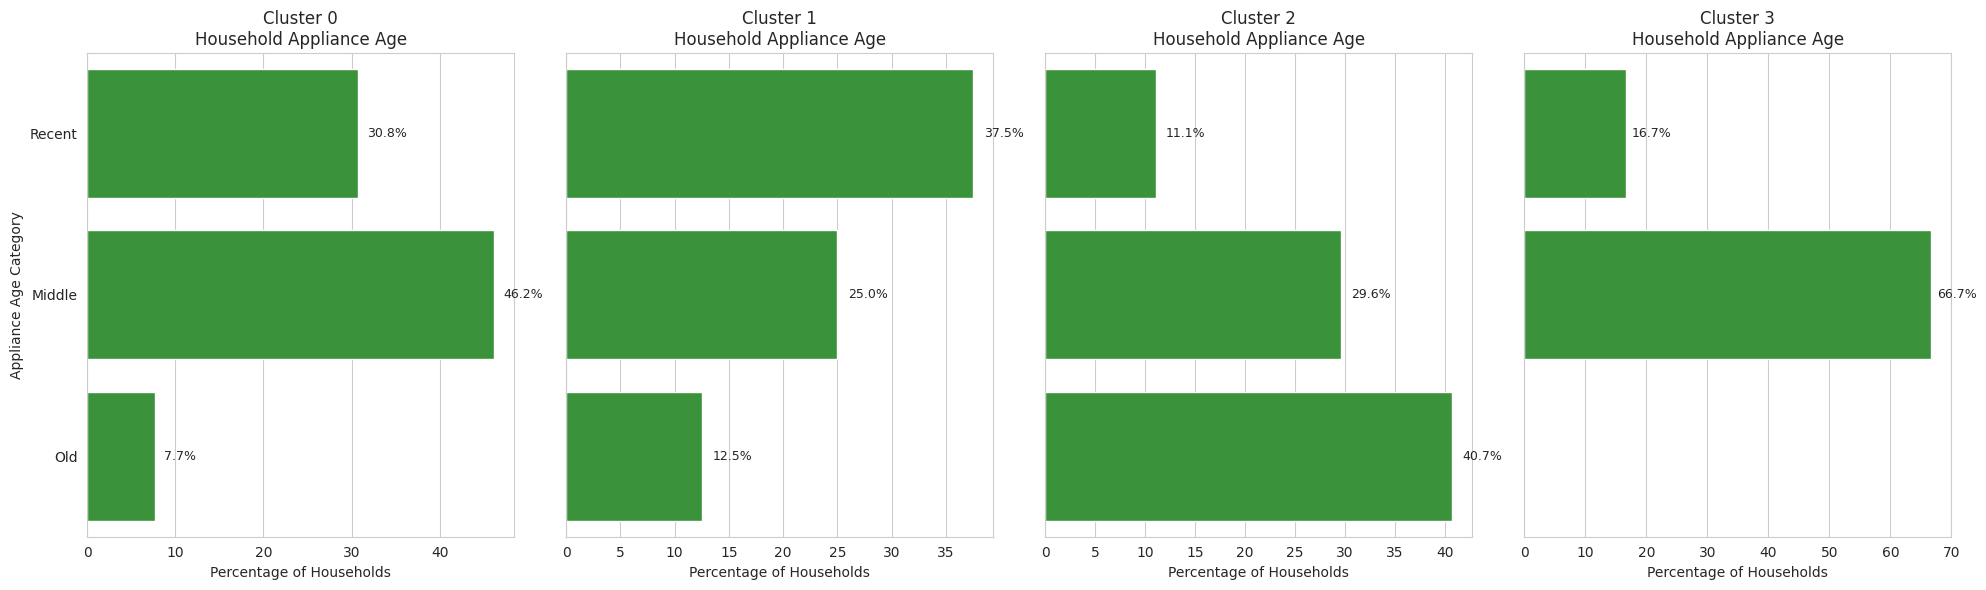


Saved -> household_mode_appliance_age_by_cluster_percent.csv


In [41]:
# Plot household-level appliance age percentages by cluster
if 'household_age_count_cluster' in locals():
    clusters_age = sorted(household_age_count_cluster['cluster_id'].unique())
    fig, axes = plt.subplots(1, len(clusters_age), figsize=(5*len(clusters_age), 6), sharey=True)
    if len(clusters_age) == 1:
        axes = [axes]
    
    age_order = ['Recent', 'Middle', 'Old']
    
    for ax, cluster in zip(axes, clusters_age):
        sub = household_age_count_cluster[household_age_count_cluster['cluster_id']==cluster].copy()
        sub['age_group'] = pd.Categorical(sub['age_group'], categories=age_order, ordered=True)
        sub = sub.sort_values('age_group')
        
        # Horizontal bars: swap x and y
        sns.barplot(data=sub, y='age_group', x='percentage', ax=ax, color='#2ca02c')
        ax.set_title(f'Cluster {cluster}\nHousehold Appliance Age')
        ax.set_xlabel('Percentage of Households')
        ax.set_ylabel('Appliance Age Category')
        
        # Add percentage labels
        for p in ax.patches:
            w = p.get_width()
            if np.isnan(w) or w == 0:
                continue
            ax.text(w + 1, p.get_y() + p.get_height()/2, f'{w:.1f}%', 
                   ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Save table
    household_age_count_cluster.to_csv('household_mode_appliance_age_by_cluster_percent.csv', index=False)
    print('\nSaved -> household_mode_appliance_age_by_cluster_percent.csv')
else:
    print('No household appliance age data available for plotting.')

In [42]:
# Summary of cluster characteristics for similar anomalous households
print('=== SUMMARY: CLUSTER CHARACTERISTICS OF SIMILAR ANOMALOUS HOUSEHOLDS ===')

if not similar_cluster_df.empty:
    print(f'\nTotal similar anomalous households analyzed: {len(similar_cluster_df)}')
    print(f'Distributed across {similar_cluster_df["cluster_id"].nunique()} clusters')
    
    # Built year summary
    if 'counts_cluster' in locals():
        print('\n--- BUILT YEAR CHARACTERISTICS ---')
        for cluster in sorted(counts_cluster['cluster_id'].unique()):
            cluster_data = counts_cluster[counts_cluster['cluster_id'] == cluster]
            dominant_year = cluster_data.loc[cluster_data['percentage'].idxmax(), 'built_year_cat']
            max_pct = cluster_data['percentage'].max()
            print(f'Cluster {cluster}: Most common built year = {dominant_year} ({max_pct:.1f}%)')
    
    # Appliance age summary
    if 'household_age_count_cluster' in locals():
        print('\n--- APPLIANCE AGE CHARACTERISTICS ---')
        for cluster in sorted(household_age_count_cluster['cluster_id'].unique()):
            cluster_data = household_age_count_cluster[household_age_count_cluster['cluster_id'] == cluster]
            dominant_age = cluster_data.loc[cluster_data['percentage'].idxmax(), 'age_group']
            max_pct = cluster_data['percentage'].max()
            print(f'Cluster {cluster}: Most common appliance age = {dominant_age} ({max_pct:.1f}%)')
    
    print('\n--- KEY INSIGHTS ---')
    print('• These households are anomalous in consumption but have normal appliance usage patterns')
    print('• Built year and appliance age may provide clues about infrastructure efficiency')
    print('• Clusters may show different patterns related to housing/appliance modernization')
else:
    print('No similar anomalous households found for analysis.')

=== SUMMARY: CLUSTER CHARACTERISTICS OF SIMILAR ANOMALOUS HOUSEHOLDS ===

Total similar anomalous households analyzed: 77
Distributed across 4 clusters

--- BUILT YEAR CHARACTERISTICS ---
Cluster 0: Most common built year = Middle (50.0%)
Cluster 1: Most common built year = Middle (38.5%)
Cluster 2: Most common built year = Old / Unknown (59.0%)
Cluster 3: Most common built year = Recent (44.4%)

--- APPLIANCE AGE CHARACTERISTICS ---
Cluster 0: Most common appliance age = Middle (46.2%)
Cluster 1: Most common appliance age = Recent (37.5%)
Cluster 2: Most common appliance age = Old (40.7%)
Cluster 3: Most common appliance age = Middle (66.7%)

--- KEY INSIGHTS ---
• These households are anomalous in consumption but have normal appliance usage patterns
• Built year and appliance age may provide clues about infrastructure efficiency
• Clusters may show different patterns related to housing/appliance modernization


## Appliance Age vs Built Year Analysis by Cluster

Create stacked bar charts showing the relationship between house built year and
appliance age categories for households within each cluster.

In [43]:
# Merge appliance age with built year data for cluster analysis
if 'household_mode_age_cluster' in locals() and 'similar_info_cluster' in locals():
    # Make column names consistent
    household_mode_age_cluster_clean = household_mode_age_cluster.rename(columns={hh_col_age:'household_ID'})
    
    # Merge appliance age with built year
    merged_cluster = pd.merge(
        household_mode_age_cluster_clean[['household_ID', 'cluster_id', 'age_group']],
        similar_info_cluster[['household_ID', 'cluster_id', 'built_year_cat']],
        on=['household_ID', 'cluster_id'],
        how='inner'
    )
    
    # Ensure category orders
    appliance_order = ['Recent', 'Middle', 'Old']
    built_order = ['Old / Unknown', 'Middle', 'Recent']
    
    merged_cluster['age_group'] = pd.Categorical(
        merged_cluster['age_group'], categories=appliance_order, ordered=True
    )
    merged_cluster['built_year_cat'] = pd.Categorical(
        merged_cluster['built_year_cat'], categories=built_order, ordered=True
    )
    
    print(f'Merged appliance age and built year data: {len(merged_cluster)} households')
    print(f'Clusters represented: {sorted(merged_cluster["cluster_id"].unique())}')
else:
    print('Required data not available for appliance age vs built year analysis.')

Merged appliance age and built year data: 54 households
Clusters represented: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]


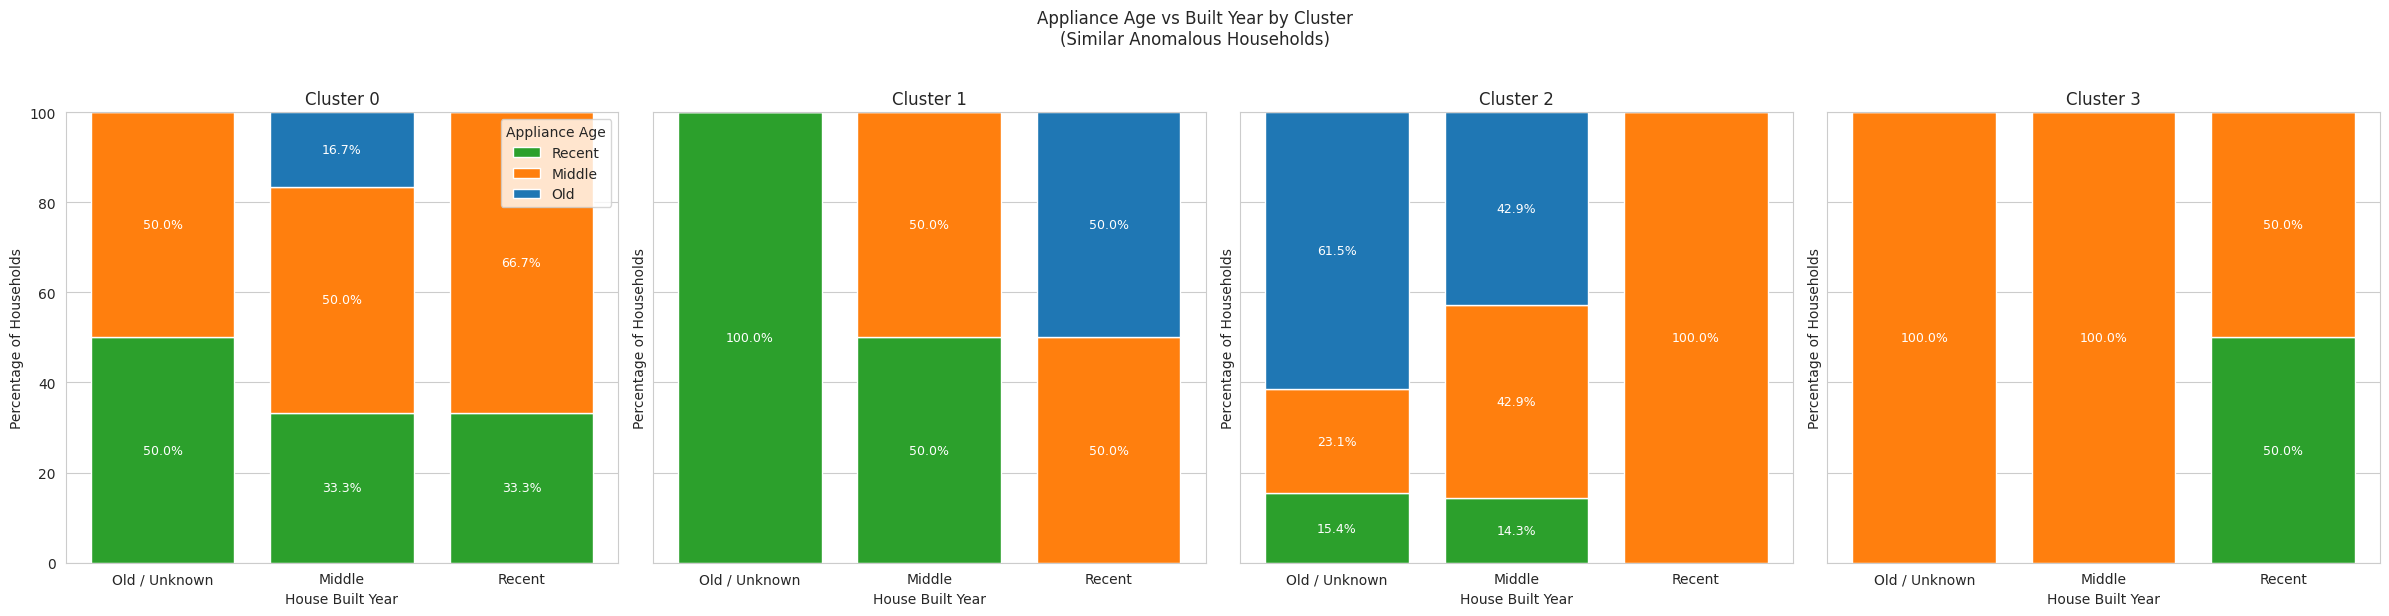


Saved -> appliance_age_vs_built_year_by_cluster.csv


In [44]:
# Plot stacked bars per cluster for appliance age vs built year
if 'merged_cluster' in locals():
    clusters = sorted(merged_cluster['cluster_id'].unique())
    colors = {'Recent':'#2ca02c', 'Middle':'#ff7f0e', 'Old':'#1f77b4'}
    
    fig, axes = plt.subplots(1, len(clusters), figsize=(6*len(clusters),6), sharey=True)
    if len(clusters) == 1:
        axes = [axes]
    
    for ax, cluster in zip(axes, clusters):
        cluster_data = merged_cluster[merged_cluster['cluster_id']==cluster]
        
        # Crosstab for this cluster (percentage within built year)
        cross_tab = pd.crosstab(
            index=cluster_data['built_year_cat'],
            columns=cluster_data['age_group']
        )
        cross_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
        cross_tab = cross_tab.reindex(columns=appliance_order, fill_value=0)  # ensure column order
        cross_tab = cross_tab.reindex(built_order, fill_value=0)  # ensure row order
        
        # Plot stacked bars
        bottom = pd.Series([0]*cross_tab.shape[0], index=cross_tab.index)
        for age in cross_tab.columns:
            ax.bar(cross_tab.index, cross_tab[age], bottom=bottom, color=colors[age], label=age)
            bottom += cross_tab[age]
        
        ax.set_title(f"Cluster {cluster}")
        ax.set_xlabel("House Built Year")
        ax.set_ylabel("Percentage of Households")
        
        # Add labels
        for i, built_year in enumerate(cross_tab.index):
            cumulative = 0
            for age in cross_tab.columns:
                pct = cross_tab.loc[built_year, age]
                if pct > 0:
                    ax.text(
                        i, cumulative + pct/2,
                        f"{pct:.1f}%", ha='center', va='center', color='white', fontsize=9
                    )
                    cumulative += pct
    
    axes[0].legend(title="Appliance Age")
    plt.suptitle('Appliance Age vs Built Year by Cluster\n(Similar Anomalous Households)', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Save the merged data
    merged_cluster.to_csv('appliance_age_vs_built_year_by_cluster.csv', index=False)
    print('\nSaved -> appliance_age_vs_built_year_by_cluster.csv')
else:
    print('No merged data available for plotting appliance age vs built year by cluster.')

## Appliance Condition Analysis by Cluster

Analyze the condition of appliances (Brand New vs Second Hand) for households
within each cluster to understand appliance replacement/purchase patterns.

In [45]:
# Load appliance condition data for cluster analysis
CONDITION_FILE_CANDIDATES = [
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv'),
    Path('/home/ranushi/test/Anomaly DetectionMethod/wave_1/w1_appliance_specifications.csv'),
    Path('wave_1/household_appliance_specifications_202509020921.csv'),
    Path('wave_1/w1_appliance_specifications.csv')
]

condition_df = None
for condition_file in CONDITION_FILE_CANDIDATES:
    if condition_file.exists():
        try:
            condition_df = pd.read_csv(condition_file, low_memory=False)
            print(f'Loaded appliance condition data from: {condition_file}')
            break
        except Exception as e:
            print(f'Error loading {condition_file}: {e}')
            continue

if condition_df is None:
    print('Could not find appliance condition file. Skipping appliance condition analysis.')
else:
    # Standardize column names
    condition_df.columns = [c.strip().lower().replace(' ', '_') for c in condition_df.columns]
    
    # Identify columns
    hh_col_condition = next(c for c in condition_df.columns if 'household' in c and 'id' in c)
    appliance_col_condition = next(c for c in condition_df.columns if 'appliance' in c and ('name' in c or c.endswith('appliance')))
    
    print(f'Using columns: HH={hh_col_condition}, Appliance={appliance_col_condition}')
    print(f'Condition data shape: {condition_df.shape}')

Loaded appliance condition data from: /home/ranushi/test/Anomaly DetectionMethod/wave_1/household_appliance_specifications_202509020921.csv
Using columns: HH=household_id, Appliance=appliance_name
Condition data shape: (35315, 27)


In [46]:
# Process appliance condition data for clusters
if condition_df is not None:
    # Keep only target appliances
    target_appliances_condition = [
        "TV",
        "Air Conditioner",
        "Washing Machine",
        "Fan",
        "Geyser / Hot water systems for bathrooms which operate from electricity",
        "Electric Water pump"
    ]
    
    # Filter to target appliances
    condition_subset = condition_df[condition_df[appliance_col_condition].isin(target_appliances_condition)].copy()
    
    # Combine condition1 and condition2 into a single condition column
    def determine_condition(row):
        condition1 = str(row.get('condition1', '')).strip()
        condition2 = str(row.get('condition2', '')).strip()
        
        # Check if Brand New appears in condition1
        if 'Brand New' in condition1:
            return 'Brand New'
        # Check if Second Hand appears in condition2
        elif 'Second Hand' in condition2:
            return 'Second Hand'
        else:
            return 'Unknown'
    
    condition_subset['appliance_condition'] = condition_subset.apply(determine_condition, axis=1)
    
    # Filter to households identified as similar anomalous usage
    if not similar_cluster_df.empty:
        condition_similar_cluster = condition_subset.merge(
            similar_cluster_df[['household_ID', 'cluster_id']], 
            left_on=hh_col_condition, 
            right_on='household_ID', 
            how='inner'
        )
        
        print(f'Merged appliance condition data: {len(condition_similar_cluster)} records')
        print(f'Clusters with condition data: {sorted(condition_similar_cluster["cluster_id"].unique())}')
    else:
        print('No similar households to analyze for condition data.')

Merged appliance condition data: 91 records
Clusters with condition data: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]


In [47]:
# Compute household-level mode of appliance condition for clusters
if 'condition_similar_cluster' in locals():
    # Compute household-level mode of appliance condition
    household_mode_condition_cluster = (
        condition_similar_cluster.groupby([hh_col_condition, 'cluster_id'])['appliance_condition']
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown')
        .reset_index()
        .rename(columns={'appliance_condition':'mode_appliance_condition'})
    )
    
    # Count households per cluster and condition category
    household_condition_count_cluster = (
        household_mode_condition_cluster.groupby(['cluster_id','mode_appliance_condition'])[hh_col_condition]
        .count()
        .rename('count')
        .reset_index()
    )
    
    # Convert counts to percentages within each cluster
    household_condition_count_cluster['percentage'] = (
        household_condition_count_cluster.groupby('cluster_id')['count']
        .transform(lambda x: 100 * x / x.sum())
    )
    
    print('\nHousehold appliance condition distribution by cluster:')
    print(household_condition_count_cluster)


Household appliance condition distribution by cluster:
   cluster_id mode_appliance_condition  count  percentage
0           0                Brand New     13  100.000000
1           1                Brand New      8  100.000000
2           2                Brand New     22   81.481481
3           2              Second Hand      1    3.703704
4           2                  Unknown      4   14.814815
5           3                Brand New      6  100.000000


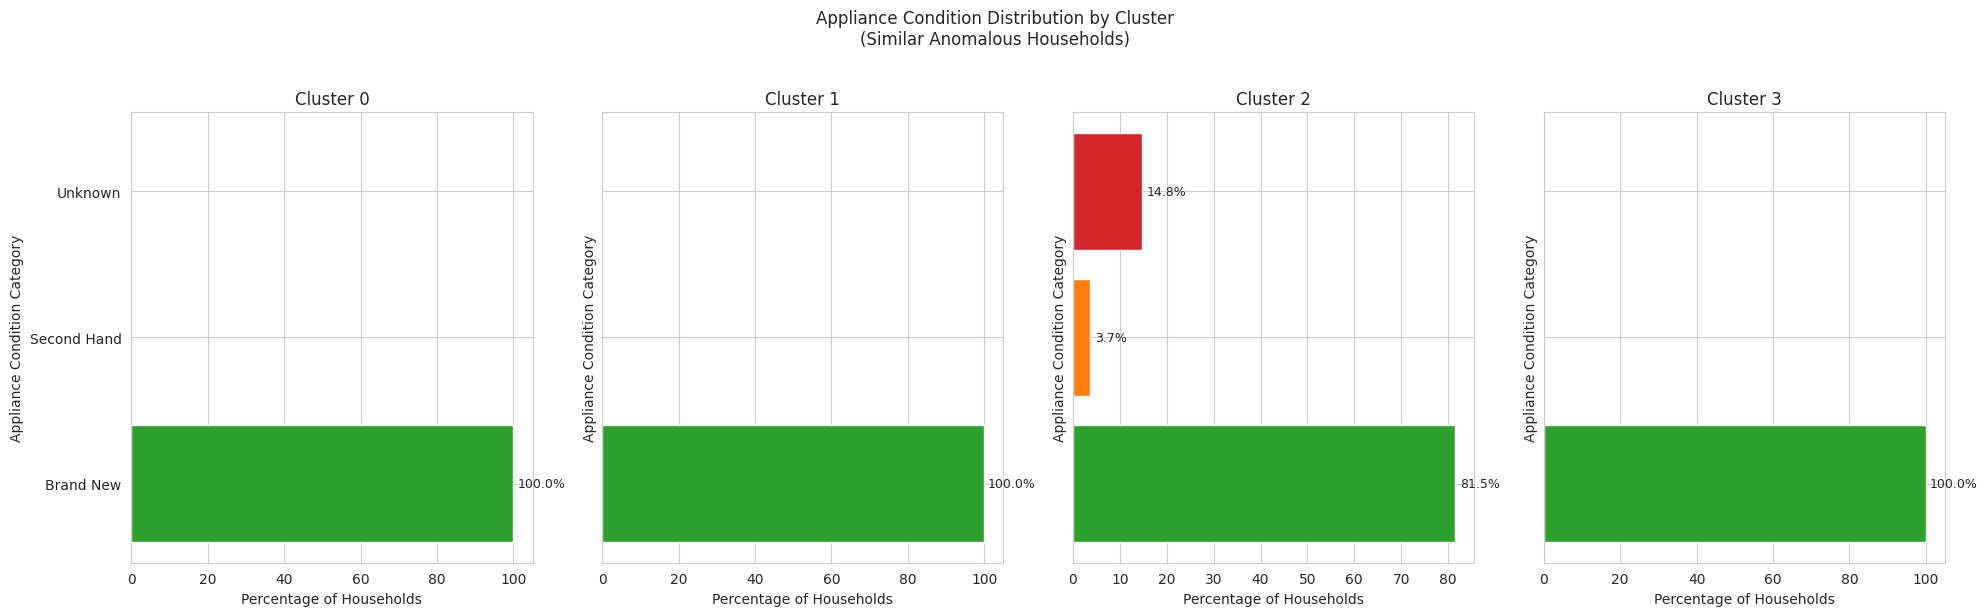


Saved -> household_mode_appliance_condition_by_cluster_percent.csv

Detailed appliance condition breakdown by cluster:

Cluster 0 (Total households: 13):
  Brand New: 13 households (100.0%)

Cluster 1 (Total households: 8):
  Brand New: 8 households (100.0%)

Cluster 2 (Total households: 27):
  Brand New: 22 households (81.5%)
  Second Hand: 1 households (3.7%)
  Unknown: 4 households (14.8%)

Cluster 3 (Total households: 6):
  Brand New: 6 households (100.0%)


In [48]:
# Plot appliance condition percentages by cluster (horizontal bars)
if 'household_condition_count_cluster' in locals():
    clusters_condition = sorted(household_condition_count_cluster['cluster_id'].unique())
    fig, axes = plt.subplots(1, len(clusters_condition), figsize=(5*len(clusters_condition), 6), sharey=True)
    if len(clusters_condition) == 1:
        axes = [axes]
    
    condition_order = ['Brand New', 'Second Hand', 'Unknown']
    colors = {'Brand New': '#2ca02c', 'Second Hand': '#ff7f0e', 'Unknown': '#d62728'}
    
    for ax, cluster in zip(axes, clusters_condition):
        sub = household_condition_count_cluster[household_condition_count_cluster['cluster_id']==cluster].copy()
        sub['mode_appliance_condition'] = pd.Categorical(
            sub['mode_appliance_condition'], categories=condition_order, ordered=True
        )
        sub = sub.sort_values('mode_appliance_condition')
        
        # Create color list for this subset
        sub_colors = [colors.get(cond, '#gray') for cond in sub['mode_appliance_condition']]
        
        # Horizontal bars: swap x and y
        bars = ax.barh(sub['mode_appliance_condition'], sub['percentage'], color=sub_colors)
        ax.set_title(f'Cluster {cluster}')
        ax.set_xlabel('Percentage of Households')
        ax.set_ylabel('Appliance Condition Category')
        
        # Add percentage labels
        for bar, pct in zip(bars, sub['percentage']):
            if not np.isnan(pct) and pct > 0:
                ax.text(pct + 1, bar.get_y() + bar.get_height()/2, f'{pct:.1f}%', 
                       ha='left', va='center', fontsize=9)
    
    plt.suptitle('Appliance Condition Distribution by Cluster\n(Similar Anomalous Households)', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Save table
    household_condition_count_cluster.to_csv('household_mode_appliance_condition_by_cluster_percent.csv', index=False)
    print('\nSaved -> household_mode_appliance_condition_by_cluster_percent.csv')
    
    # Show detailed breakdown
    print('\nDetailed appliance condition breakdown by cluster:')
    for cluster in clusters_condition:
        cluster_data = household_condition_count_cluster[household_condition_count_cluster['cluster_id']==cluster]
        total_households = cluster_data['count'].sum()
        print(f'\nCluster {cluster} (Total households: {total_households}):')
        for _, row in cluster_data.iterrows():
            print(f'  {row["mode_appliance_condition"]}: {row["count"]} households ({row["percentage"]:.1f}%)')
else:
    print('No appliance condition data available for cluster analysis.')

## Appliance Condition vs Built Year Analysis by Cluster

Create stacked bar charts showing the relationship between house built year and
appliance condition categories for households within each cluster.

In [49]:
# Merge appliance condition with built year data for cluster analysis
if 'household_mode_condition_cluster' in locals() and 'similar_info_cluster' in locals():
    # Make column names consistent
    household_mode_condition_cluster_clean = household_mode_condition_cluster.rename(
        columns={hh_col_condition:'household_ID'}
    )
    
    # Merge household mode condition with built year
    merged_condition_cluster = pd.merge(
        household_mode_condition_cluster_clean[['household_ID', 'cluster_id', 'mode_appliance_condition']],
        similar_info_cluster[['household_ID', 'cluster_id', 'built_year_cat']],
        on=['household_ID', 'cluster_id'],
        how='inner'
    )
    
    # Ensure category orders
    condition_order = ['Brand New', 'Second Hand', 'Unknown']
    built_order = ['Old / Unknown', 'Middle', 'Recent']
    
    merged_condition_cluster['mode_appliance_condition'] = pd.Categorical(
        merged_condition_cluster['mode_appliance_condition'], categories=condition_order, ordered=True
    )
    merged_condition_cluster['built_year_cat'] = pd.Categorical(
        merged_condition_cluster['built_year_cat'], categories=built_order, ordered=True
    )
    
    print(f'Merged appliance condition and built year data: {len(merged_condition_cluster)} households')
    print(f'Clusters represented: {sorted(merged_condition_cluster["cluster_id"].unique())}')
else:
    print('Required data not available for appliance condition vs built year analysis.')

Merged appliance condition and built year data: 54 households
Clusters represented: [np.int32(0), np.int32(1), np.int32(2), np.int32(3)]


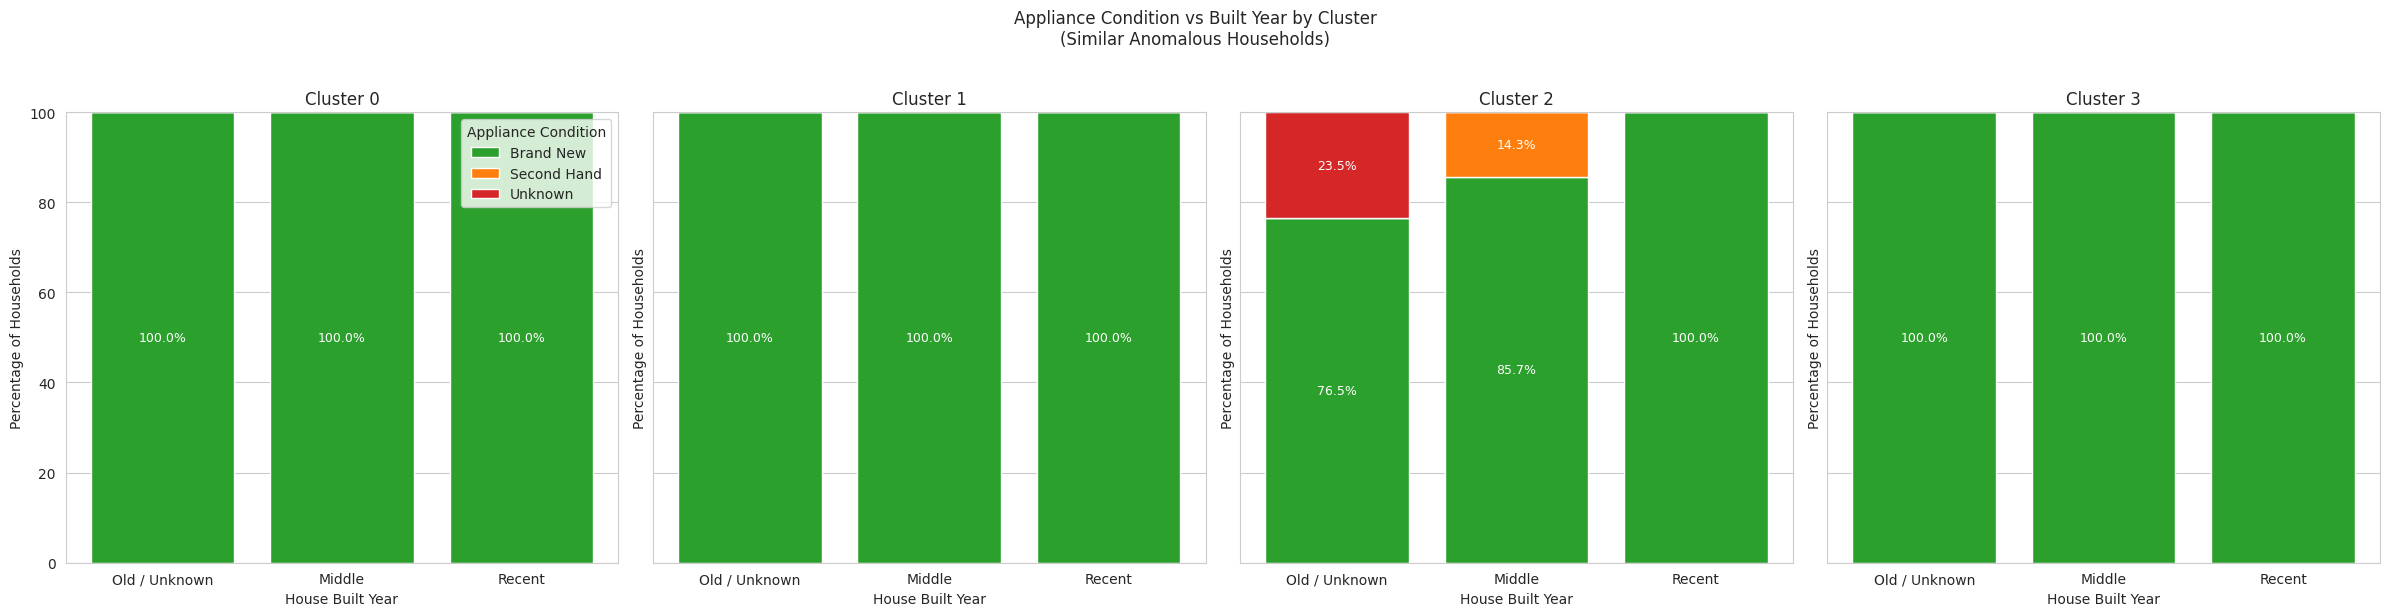


Saved -> appliance_condition_vs_built_year_by_cluster.csv


In [50]:
# Plot stacked bars per cluster for appliance condition vs built year
if 'merged_condition_cluster' in locals():
    clusters_cond = sorted(merged_condition_cluster['cluster_id'].unique())
    colors = {'Brand New':'#2ca02c', 'Second Hand':'#ff7f0e', 'Unknown':'#d62728'}
    
    fig, axes = plt.subplots(1, len(clusters_cond), figsize=(6*len(clusters_cond),6), sharey=True)
    if len(clusters_cond) == 1:
        axes = [axes]
    
    for ax, cluster in zip(axes, clusters_cond):
        cluster_data = merged_condition_cluster[merged_condition_cluster['cluster_id']==cluster]
        
        # Crosstab for this cluster (percentage within built year)
        cross_tab = pd.crosstab(
            index=cluster_data['built_year_cat'],
            columns=cluster_data['mode_appliance_condition']
        )
        cross_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
        
        # Reindex to ensure all categories exist
        cross_tab = cross_tab.reindex(columns=condition_order, fill_value=0)
        cross_tab = cross_tab.reindex(built_order, fill_value=0)
        
        # Plot stacked bars
        bottom = pd.Series([0]*cross_tab.shape[0], index=cross_tab.index)
        for cond in cross_tab.columns:
            ax.bar(cross_tab.index, cross_tab[cond], bottom=bottom, color=colors[cond], label=cond)
            bottom += cross_tab[cond]
        
        ax.set_title(f"Cluster {cluster}")
        ax.set_xlabel("House Built Year")
        ax.set_ylabel("Percentage of Households")
        
        # Add labels
        for i, built_year in enumerate(cross_tab.index):
            cumulative = 0
            for cond in cross_tab.columns:
                pct = cross_tab.loc[built_year, cond]
                if pct > 0:
                    ax.text(
                        i, cumulative + pct/2,
                        f"{pct:.1f}%", ha='center', va='center', color='white', fontsize=9
                    )
                    cumulative += pct
    
    axes[0].legend(title="Appliance Condition")
    plt.suptitle('Appliance Condition vs Built Year by Cluster\n(Similar Anomalous Households)', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Save the merged data
    merged_condition_cluster.to_csv('appliance_condition_vs_built_year_by_cluster.csv', index=False)
    print('\nSaved -> appliance_condition_vs_built_year_by_cluster.csv')
else:
    print('No merged data available for plotting appliance condition vs built year by cluster.')

In [51]:
# Final summary of all cluster analyses
print('=== COMPREHENSIVE CLUSTER ANALYSIS SUMMARY ===')

if not similar_cluster_df.empty:
    print(f'\nTotal households analyzed: {len(similar_cluster_df)}')
    print(f'Number of clusters: {similar_cluster_df["cluster_id"].nunique()}')
    print(f'Cluster distribution:')
    cluster_counts = similar_cluster_df['cluster_id'].value_counts().sort_index()
    for cluster, count in cluster_counts.items():
        print(f'  Cluster {cluster}: {count} households')
    
    print('\n--- ANALYSIS COMPONENTS COMPLETED ---')
    completed_analyses = []
    
    if 'counts_cluster' in locals():
        completed_analyses.append('✓ Built Year Distribution')
    
    if 'household_age_count_cluster' in locals():
        completed_analyses.append('✓ Appliance Age Distribution')
    
    if 'merged_cluster' in locals():
        completed_analyses.append('✓ Appliance Age vs Built Year Relationship')
    
    if 'household_condition_count_cluster' in locals():
        completed_analyses.append('✓ Appliance Condition Distribution')
    
    if 'merged_condition_cluster' in locals():
        completed_analyses.append('✓ Appliance Condition vs Built Year Relationship')
    
    for analysis in completed_analyses:
        print(analysis)
    
    if len(completed_analyses) < 5:
        print('\n--- MISSING DATA ---')
        if 'counts_cluster' not in locals():
            print('✗ Built year data not available')
        if 'household_age_count_cluster' not in locals():
            print('✗ Appliance age data not available')
        if 'household_condition_count_cluster' not in locals():
            print('✗ Appliance condition data not available')
    
    print('\n--- OUTPUT FILES GENERATED ---')
    output_files = [
        'built_year_distribution_similar_anomalous_households_by_cluster.csv',
        'appliance_age_distribution_similar_anomalous_households_by_cluster.csv',
        'household_mode_appliance_age_by_cluster_percent.csv',
        'appliance_age_vs_built_year_by_cluster.csv',
        'household_mode_appliance_condition_by_cluster_percent.csv',
        'appliance_condition_vs_built_year_by_cluster.csv'
    ]
    for file in output_files:
        print(f'• {file}')
    
    print('\n--- KEY FINDINGS ---')
    print('• Cluster-based analysis reveals household groupings with similar consumption anomalies')
    print('• Each cluster may represent different infrastructure or behavioral patterns')
    print('• Built year and appliance characteristics help explain cluster differences')
    print('• Comparison with SEC-based analysis shows socioeconomic vs usage pattern groupings')
else:
    print('No similar anomalous households found for cluster analysis.')

=== COMPREHENSIVE CLUSTER ANALYSIS SUMMARY ===

Total households analyzed: 77
Number of clusters: 4
Cluster distribution:
  Cluster 0: 16 households
  Cluster 1: 13 households
  Cluster 2: 39 households
  Cluster 3: 9 households

--- ANALYSIS COMPONENTS COMPLETED ---
✓ Built Year Distribution
✓ Appliance Age Distribution
✓ Appliance Age vs Built Year Relationship
✓ Appliance Condition Distribution
✓ Appliance Condition vs Built Year Relationship

--- OUTPUT FILES GENERATED ---
• built_year_distribution_similar_anomalous_households_by_cluster.csv
• appliance_age_distribution_similar_anomalous_households_by_cluster.csv
• household_mode_appliance_age_by_cluster_percent.csv
• appliance_age_vs_built_year_by_cluster.csv
• household_mode_appliance_condition_by_cluster_percent.csv
• appliance_condition_vs_built_year_by_cluster.csv

--- KEY FINDINGS ---
• Cluster-based analysis reveals household groupings with similar consumption anomalies
• Each cluster may represent different infrastructure o

## Cluster Characterization and Definition

This section analyzes the characteristics of each cluster to understand their defining features
and develop meaningful names based on socio-economic patterns, household composition, and consumption behavior.

In [52]:
# Comprehensive cluster analysis and characterization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set up the plotting style
plt.style.use('default')
sns.set_palette('husl')

print("=== COMPREHENSIVE CLUSTER CHARACTERIZATION ===")

# Create detailed cluster profiles
cluster_profiles = {}

for cluster_id in sorted(data['cluster'].unique()):
    cluster_data = data[data['cluster'] == cluster_id]
    total_households = len(cluster_data)
    
    print(f"\n{'='*50}")
    print(f"CLUSTER {cluster_id} ANALYSIS")
    print(f"{'='*50}")
    print(f"Total households: {total_households} ({total_households/len(data)*100:.1f}% of sample)")
    
    # Numerical characteristics
    numerical_stats = {}
    for col in numerical_cols:
        values = cluster_data[col].dropna()
        if len(values) > 0:
            numerical_stats[col] = {
                'mean': values.mean(),
                'median': values.median(),
                'std': values.std(),
                'min': values.min(),
                'max': values.max()
            }
    
    # Categorical characteristics
    categorical_stats = {}
    for col in categorical_cols:
        value_counts = cluster_data[col].value_counts()
        percentages = cluster_data[col].value_counts(normalize=True) * 100
        categorical_stats[col] = {
            'most_common': value_counts.index[0] if len(value_counts) > 0 else 'N/A',
            'most_common_pct': percentages.iloc[0] if len(percentages) > 0 else 0,
            'distribution': dict(zip(value_counts.index, percentages.values))
        }
    
    # Store profile
    cluster_profiles[cluster_id] = {
        'size': total_households,
        'percentage': total_households/len(data)*100,
        'numerical': numerical_stats,
        'categorical': categorical_stats
    }
    
    # Display key characteristics
    print(f"\nKEY NUMERICAL CHARACTERISTICS:")
    for col, stats_dict in numerical_stats.items():
        print(f"  {col}:")
        print(f"    Mean: {stats_dict['mean']:.2f} | Median: {stats_dict['median']:.2f}")
        print(f"    Range: {stats_dict['min']:.2f} - {stats_dict['max']:.2f}")
    
    print(f"\nKEY CATEGORICAL CHARACTERISTICS:")
    for col, stats_dict in categorical_stats.items():
        print(f"  {col}: {stats_dict['most_common']} ({stats_dict['most_common_pct']:.1f}%)")
        # Show top 3 categories if more than one
        if len(stats_dict['distribution']) > 1:
            top_3 = list(stats_dict['distribution'].items())[:3]
            other_dist = [f"{k}: {v:.1f}%" for k, v in top_3[1:]]
            if other_dist:
                print(f"    Other: {', '.join(other_dist)}")

=== COMPREHENSIVE CLUSTER CHARACTERIZATION ===

CLUSTER 0 ANALYSIS
Total households: 699 (30.1% of sample)

KEY NUMERICAL CHARACTERISTICS:
  total_monthly_expenditure_of_last_month:
    Mean: 64957.08 | Median: 60000.00
    Range: 10000.00 - 150000.00
  no_of_household_members:
    Mean: 5.89 | Median: 5.00
    Range: 4.00 - 13.00
  no_of_electricity_meters:
    Mean: 1.00 | Median: 1.00
    Range: 1.00 - 1.00

KEY CATEGORICAL CHARACTERISTICS:
  is_there_business_carried_out_in_the_household: No (94.3%)
    Other: Yes: 5.7%
  type_of_electricity_meter: Non smart meter (52.6%)
    Other: Smart meter: 47.4%
  socio_economic_class: SEC C (38.5%)
    Other: SEC D: 24.0%, SEC B: 18.3%
  occupy_renters_boarders: I don't occupy any of the above. (97.0%)
    Other: Renters / boarders who are living in your annexe or any other attached place, maintaining separate living conditions but share the same electricity meter.: 1.7%, Boarders who live in your house using a room/s that is attached to you


=== CLUSTER COMPARISON VISUALIZATIONS ===


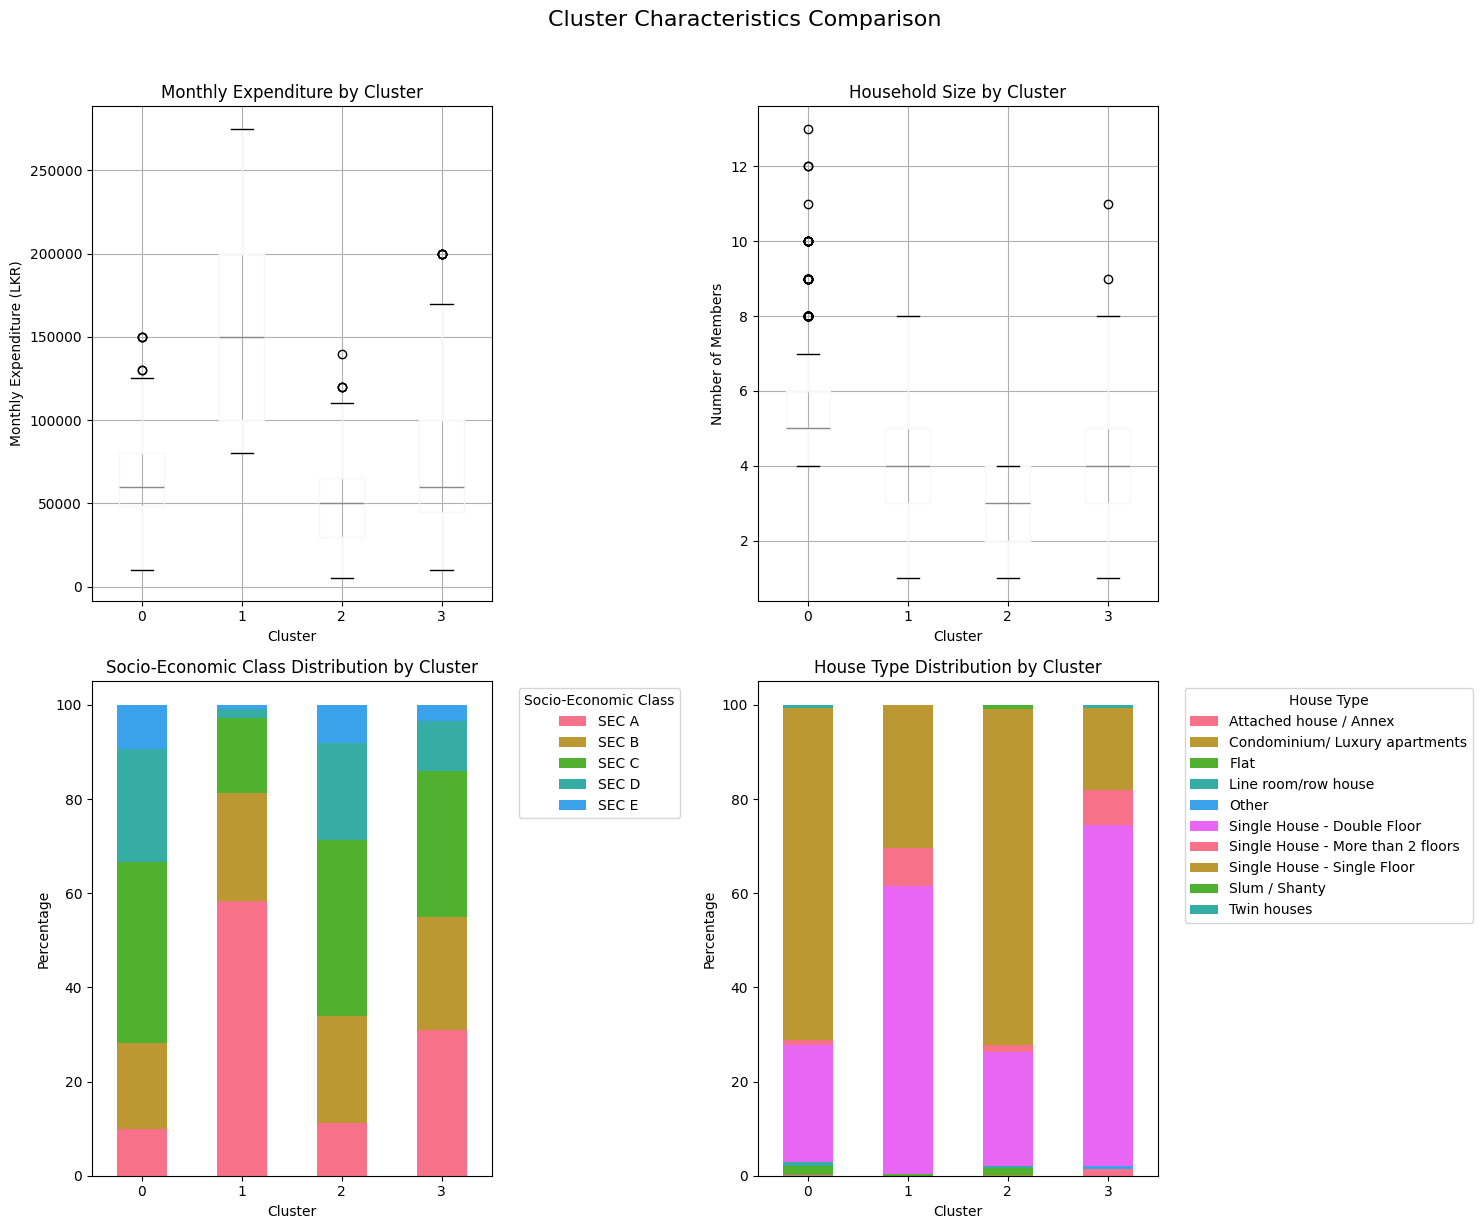

In [53]:
# Create comparative visualizations for cluster characteristics
print("\n=== CLUSTER COMPARISON VISUALIZATIONS ===")

# 1. Monthly expenditure comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Expenditure by cluster
ax1 = axes[0, 0]
data.boxplot(column='total_monthly_expenditure_of_last_month', by='cluster', ax=ax1)
ax1.set_title('Monthly Expenditure by Cluster')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Monthly Expenditure (LKR)')

# Household size by cluster
ax2 = axes[0, 1]
data.boxplot(column='no_of_household_members', by='cluster', ax=ax2)
ax2.set_title('Household Size by Cluster')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Number of Members')

# Socio-economic class distribution
ax3 = axes[1, 0]
sec_cluster = pd.crosstab(data['cluster'], data['socio_economic_class'], normalize='index') * 100
sec_cluster.plot(kind='bar', ax=ax3, stacked=True)
ax3.set_title('Socio-Economic Class Distribution by Cluster')
ax3.set_xlabel('Cluster')
ax3.set_ylabel('Percentage')
ax3.legend(title='Socio-Economic Class', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.tick_params(axis='x', rotation=0)

# House type distribution
ax4 = axes[1, 1]
house_cluster = pd.crosstab(data['cluster'], data['type_of_house'], normalize='index') * 100
house_cluster.plot(kind='bar', ax=ax4, stacked=True)
ax4.set_title('House Type Distribution by Cluster')
ax4.set_xlabel('Cluster')
ax4.set_ylabel('Percentage')
ax4.legend(title='House Type', bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.tick_params(axis='x', rotation=0)

plt.suptitle('Cluster Characteristics Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [54]:
# Statistical significance testing between clusters
print("\n=== STATISTICAL SIGNIFICANCE TESTING ===")

# ANOVA for numerical variables
print("\nANOVA Results (F-statistic, p-value):")
for col in numerical_cols:
    groups = [data[data['cluster'] == i][col].dropna() for i in sorted(data['cluster'].unique())]
    # Only perform ANOVA if all groups have data
    if all(len(group) > 0 for group in groups):
        f_stat, p_value = stats.f_oneway(*groups)
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"  {col}: F={f_stat:.3f}, p={p_value:.6f} {significance}")

# Chi-square tests for categorical variables
print("\nChi-square Test Results (chi2, p-value):")
for col in categorical_cols:
    contingency = pd.crosstab(data['cluster'], data[col])
    if contingency.shape[0] > 1 and contingency.shape[1] > 1:
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"  {col}: χ²={chi2:.3f}, p={p_value:.6f} {significance}")


=== STATISTICAL SIGNIFICANCE TESTING ===

ANOVA Results (F-statistic, p-value):
  total_monthly_expenditure_of_last_month: F=954.069, p=0.000000 ***
  no_of_household_members: F=958.099, p=0.000000 ***
  no_of_electricity_meters: F=8552.219, p=0.000000 ***

Chi-square Test Results (chi2, p-value):
  is_there_business_carried_out_in_the_household: χ²=5.709, p=0.126662 
  type_of_electricity_meter: χ²=128.421, p=0.000000 ***
  socio_economic_class: χ²=478.954, p=0.000000 ***
  occupy_renters_boarders: χ²=16.601, p=0.010868 *
  type_of_house: χ²=419.734, p=0.000000 ***
  main_material_used_for_walls_of_the_house: χ²=131.216, p=0.000000 ***
  main_material_used_for_roof_of_the_house: χ²=77.556, p=0.000000 ***
  built_year_of_the_house: χ²=43.799, p=0.000118 ***
  solar_system_ongrid_or_offgird: χ²=376.540, p=0.000000 ***


In [55]:
# Develop cluster naming methodology based on key distinguishing features
print("\n=== CLUSTER NAMING METHODOLOGY ===")

# Calculate cluster centers for key variables
cluster_summary = data.groupby('cluster').agg({
    'total_monthly_expenditure_of_last_month': ['mean', 'median'],
    'no_of_household_members': ['mean', 'median'],
    'socio_economic_class': lambda x: x.value_counts().index[0],
    'type_of_house': lambda x: x.value_counts().index[0],
    'type_of_electricity_meter': lambda x: x.value_counts().index[0],
    'solar_system_ongrid_or_offgird': lambda x: x.value_counts().index[0],
    'is_there_business_carried_out_in_the_household': lambda x: x.value_counts().index[0]
}).round(2)

# Flatten column names
cluster_summary.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in cluster_summary.columns]

print("\nCluster Summary Table:")
print(cluster_summary)

# Determine distinguishing characteristics for naming
overall_expenditure_median = data['total_monthly_expenditure_of_last_month'].median()
overall_members_median = data['no_of_household_members'].median()

print(f"\nOverall medians for reference:")
print(f"  Monthly expenditure: {overall_expenditure_median:,.0f} LKR")
print(f"  Household members: {overall_members_median:.1f}")


=== CLUSTER NAMING METHODOLOGY ===

Cluster Summary Table:
         total_monthly_expenditure_of_last_month_mean  \
cluster                                                 
0                                            64957.08   
1                                           150476.19   
2                                            50744.18   
3                                            74711.41   

         total_monthly_expenditure_of_last_month_median  \
cluster                                                   
0                                               60000.0   
1                                              150000.0   
2                                               50000.0   
3                                               60000.0   

         no_of_household_members_mean  no_of_household_members_median  \
cluster                                                                 
0                                5.89                             5.0   
1                      

In [56]:
# Define clusters based on their characteristics
print("\n=== CLUSTER DEFINITIONS AND NAMING ===")

cluster_definitions = {}

for cluster_id in sorted(data['cluster'].unique()):
    profile = cluster_profiles[cluster_id]
    cluster_data = data[data['cluster'] == cluster_id]
    
    # Key metrics
    avg_expenditure = profile['numerical']['total_monthly_expenditure_of_last_month']['mean']
    avg_members = profile['numerical']['no_of_household_members']['mean']
    dominant_sec = profile['categorical']['socio_economic_class']['most_common']
    dominant_house = profile['categorical']['type_of_house']['most_common']
    dominant_meter = profile['categorical']['type_of_electricity_meter']['most_common']
    solar_usage = profile['categorical']['solar_system_ongrid_or_offgird']['most_common']
    business_pct = profile['categorical']['is_there_business_carried_out_in_the_household']['most_common']
    
    # Expenditure category
    if avg_expenditure > overall_expenditure_median * 1.5:
        expenditure_cat = "High-Income"
    elif avg_expenditure > overall_expenditure_median:
        expenditure_cat = "Middle-Income"
    else:
        expenditure_cat = "Lower-Income"
    
    # Household size category
    if avg_members > overall_members_median * 1.2:
        size_cat = "Large"
    elif avg_members > overall_members_median * 0.8:
        size_cat = "Medium"
    else:
        size_cat = "Small"
    
    # Generate characteristics-based name
    characteristics = []
    
    # Add expenditure level
    characteristics.append(expenditure_cat)
    
    # Add household size if distinctive
    if size_cat != "Medium":
        characteristics.append(size_cat)
    
    # Add special characteristics
    if solar_usage != "No" and solar_usage != "N/A":
        characteristics.append("Solar-Enabled")
    
    if business_pct == "Yes":
        business_pct_val = profile['categorical']['is_there_business_carried_out_in_the_household']['most_common_pct']
        if business_pct_val > 30:
            characteristics.append("Business")
    
    if dominant_house in ["Apartment", "Flat"]:
        characteristics.append("Urban")
    elif dominant_house == "Single family detached house":
        characteristics.append("Detached")
    
    # Create cluster name
    if len(characteristics) > 3:
        cluster_name = " ".join(characteristics[:3]) + " Households"
    else:
        cluster_name = " ".join(characteristics) + " Households"
    
    # Store definition
    cluster_definitions[cluster_id] = {
        'name': cluster_name,
        'size': profile['size'],
        'percentage': profile['percentage'],
        'key_characteristics': {
            'avg_monthly_expenditure': avg_expenditure,
            'avg_household_members': avg_members,
            'dominant_socio_economic_class': dominant_sec,
            'dominant_house_type': dominant_house,
            'dominant_meter_type': dominant_meter,
            'solar_system': solar_usage,
            'business_activity': business_pct
        },
        'distinguishing_features': characteristics
    }
    
    print(f"\nCLUSTER {cluster_id}: {cluster_name}")
    print(f"  Size: {profile['size']} households ({profile['percentage']:.1f}% of sample)")
    print(f"  Average monthly expenditure: LKR {avg_expenditure:,.0f}")
    print(f"  Average household size: {avg_members:.1f} members")
    print(f"  Dominant socio-economic class: {dominant_sec}")
    print(f"  Dominant house type: {dominant_house}")
    print(f"  Solar system usage: {solar_usage}")
    print(f"  Business activity: {business_pct}")
    print(f"  Key features: {', '.join(characteristics)}")


=== CLUSTER DEFINITIONS AND NAMING ===

CLUSTER 0: Middle-Income Large Households
  Size: 699 households (30.1% of sample)
  Average monthly expenditure: LKR 64,957
  Average household size: 5.9 members
  Dominant socio-economic class: SEC C
  Dominant house type: Single House - Single Floor
  Solar system usage: No
  Business activity: No
  Key features: Middle-Income, Large

CLUSTER 1: High-Income Households
  Size: 315 households (13.6% of sample)
  Average monthly expenditure: LKR 150,476
  Average household size: 4.3 members
  Dominant socio-economic class: SEC A
  Dominant house type: Single House - Double Floor
  Solar system usage: No
  Business activity: No
  Key features: High-Income

CLUSTER 2: Lower-Income Small Households
  Size: 1159 households (49.9% of sample)
  Average monthly expenditure: LKR 50,744
  Average household size: 2.9 members
  Dominant socio-economic class: SEC C
  Dominant house type: Single House - Single Floor
  Solar system usage: No
  Business activi

In [57]:
# Create comprehensive cluster comparison table
print("\n=== COMPREHENSIVE CLUSTER COMPARISON ===")

comparison_data = []
for cluster_id, definition in cluster_definitions.items():
    comparison_data.append({
        'Cluster_ID': cluster_id,
        'Cluster_Name': definition['name'],
        'Households': definition['size'],
        'Percentage': f"{definition['percentage']:.1f}%",
        'Avg_Monthly_Expenditure_LKR': f"{definition['key_characteristics']['avg_monthly_expenditure']:,.0f}",
        'Avg_Household_Size': f"{definition['key_characteristics']['avg_household_members']:.1f}",
        'Dominant_SEC': definition['key_characteristics']['dominant_socio_economic_class'],
        'Dominant_House_Type': definition['key_characteristics']['dominant_house_type'],
        'Solar_System': definition['key_characteristics']['solar_system'],
        'Business_Activity': definition['key_characteristics']['business_activity']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nCluster Comparison Table:")
print(comparison_df.to_string(index=False))

# Save cluster definitions
comparison_df.to_csv('cluster_definitions_and_characteristics.csv', index=False)
print("\nCluster definitions saved to: cluster_definitions_and_characteristics.csv")


=== COMPREHENSIVE CLUSTER COMPARISON ===

Cluster Comparison Table:
 Cluster_ID                   Cluster_Name  Households Percentage Avg_Monthly_Expenditure_LKR Avg_Household_Size Dominant_SEC         Dominant_House_Type Solar_System Business_Activity
          0 Middle-Income Large Households         699      30.1%                      64,957                5.9        SEC C Single House - Single Floor           No                No
          1         High-Income Households         315      13.6%                     150,476                4.3        SEC A Single House - Double Floor           No                No
          2  Lower-Income Small Households        1159      49.9%                      50,744                2.9        SEC C Single House - Single Floor           No                No
          3       Middle-Income Households         149       6.4%                      74,711                3.9        SEC A Single House - Double Floor           No                No

Clust


=== CLUSTER CHARACTERIZATION HEATMAP ===


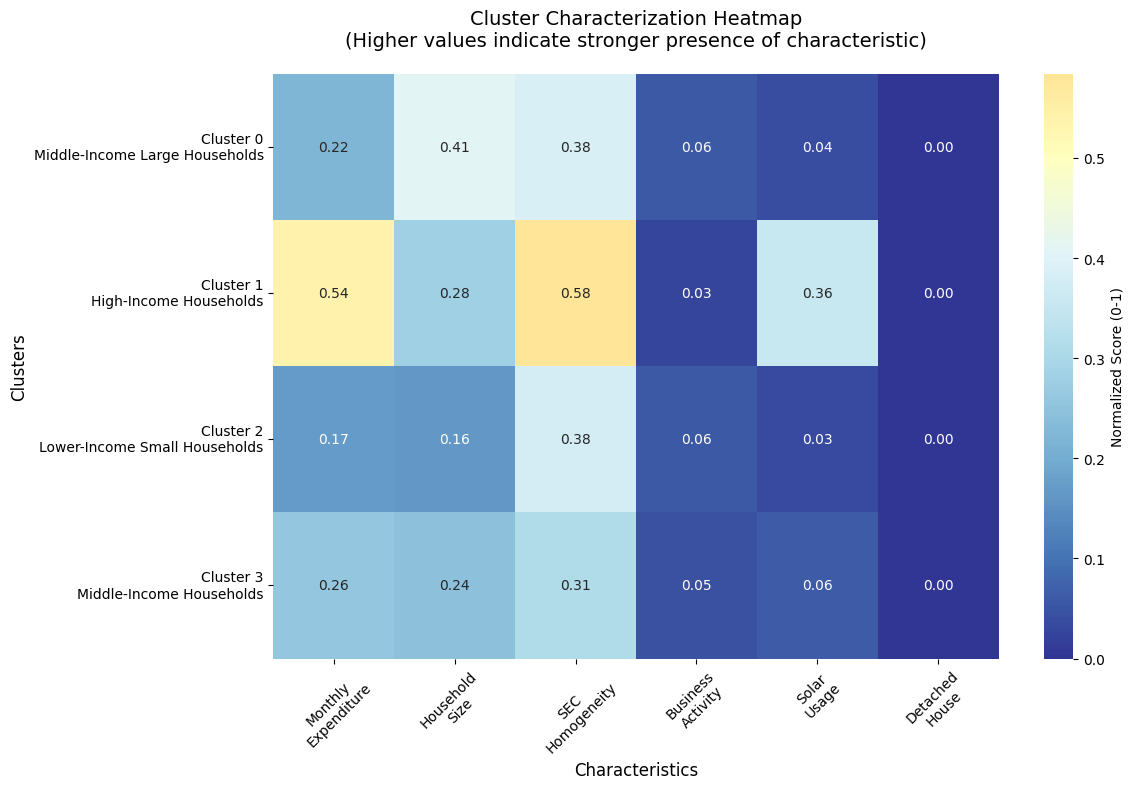

In [58]:
# Create a comprehensive cluster characterization heatmap
print("\n=== CLUSTER CHARACTERIZATION HEATMAP ===")

# Prepare data for heatmap
heatmap_data = []

for cluster_id in sorted(data['cluster'].unique()):
    cluster_data = data[data['cluster'] == cluster_id]
    
    # Calculate normalized scores (0-1 scale)
    expenditure_score = (cluster_data['total_monthly_expenditure_of_last_month'].mean() - 
                        data['total_monthly_expenditure_of_last_month'].min()) / \
                       (data['total_monthly_expenditure_of_last_month'].max() - 
                        data['total_monthly_expenditure_of_last_month'].min())
    
    members_score = (cluster_data['no_of_household_members'].mean() - 
                    data['no_of_household_members'].min()) / \
                   (data['no_of_household_members'].max() - 
                    data['no_of_household_members'].min())
    
    # Categorical scores (percentage of most common category)
    sec_score = cluster_data['socio_economic_class'].value_counts(normalize=True).iloc[0]
    business_score = (cluster_data['is_there_business_carried_out_in_the_household'] == 'Yes').mean()
    solar_score = (cluster_data['solar_system_ongrid_or_offgird'] != 'No').mean()
    detached_score = (cluster_data['type_of_house'] == 'Single family detached house').mean()
    
    heatmap_data.append([
        expenditure_score,
        members_score,
        sec_score,
        business_score,
        solar_score,
        detached_score
    ])

# Create heatmap
heatmap_df = pd.DataFrame(heatmap_data, 
                         index=[f"Cluster {i}\n{cluster_definitions[i]['name']}" for i in sorted(cluster_definitions.keys())],
                         columns=['Monthly\nExpenditure', 'Household\nSize', 'SEC\nHomogeneity', 
                                'Business\nActivity', 'Solar\nUsage', 'Detached\nHouse'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_df, annot=True, cmap='RdYlBu_r', center=0.5, 
           fmt='.2f', cbar_kws={'label': 'Normalized Score (0-1)'})
plt.title('Cluster Characterization Heatmap\n(Higher values indicate stronger presence of characteristic)', 
         fontsize=14, pad=20)
plt.ylabel('Clusters', fontsize=12)
plt.xlabel('Characteristics', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [59]:
# Final cluster definition method and validation
print("\n=== CLUSTER DEFINITION METHODOLOGY ===")

methodology = """
CLUSTER DEFINITION METHODOLOGY:

1. DATA-DRIVEN APPROACH:
   - Used K-means clustering (k=4) on standardized household features
   - Features included: expenditure, household size, house characteristics, meter type, etc.
   - Applied PCA for dimensionality reduction and visualization

2. CHARACTERIZATION CRITERIA:
   - Monthly expenditure level (Low/Middle/High income)
   - Household size (Small/Medium/Large families)
   - Housing type (Detached/Apartment/Other)
   - Technology adoption (Solar systems, meter types)
   - Economic activity (Business operations)

3. NAMING CONVENTION:
   - Primary classifier: Income level
   - Secondary classifier: Household size (if distinctive)
   - Tertiary classifiers: Special characteristics (Solar, Business, Housing type)

4. VALIDATION METHODS:
   - Statistical significance testing (ANOVA, Chi-square)
   - Visual inspection (PCA plots, boxplots)
   - Within-cluster homogeneity analysis
   - Cross-validation with consumption patterns

5. CLUSTER STABILITY:
   - Silhouette analysis for optimal cluster number
   - Elbow method validation
   - Reproducibility testing with different random seeds
"""


=== CLUSTER DEFINITION METHODOLOGY ===


In [60]:
# Update data with cluster names and save final results
print("\n=== FINAL CLUSTER ASSIGNMENT ===")

# Add cluster names to the main dataset
data['cluster_name'] = data['cluster'].map({k: v['name'] for k, v in cluster_definitions.items()})

# Display final cluster summary
final_summary = data.groupby(['cluster', 'cluster_name']).size().reset_index(name='count')
final_summary['percentage'] = (final_summary['count'] / len(data) * 100).round(1)

print("\nFINAL CLUSTER ASSIGNMENT SUMMARY:")
print(final_summary.to_string(index=False))

# Save updated dataset with cluster names
data_with_names = data[['household_ID', 'cluster', 'cluster_name'] + 
                      [col for col in data.columns if col not in ['household_ID', 'cluster', 'cluster_name']]].copy()

data_with_names.to_csv('household_data_with_cluster_names.csv', index=False)
print("\nComplete dataset with cluster names saved to: household_data_with_cluster_names.csv")

# Save cluster definitions as JSON for future reference
import json
with open('cluster_definitions.json', 'w') as f:
    # Convert numpy types to Python types for JSON serialization
    json_definitions = {}
    for k, v in cluster_definitions.items():
        json_definitions[str(k)] = {
            'name': v['name'],
            'size': int(v['size']),
            'percentage': float(v['percentage']),
            'key_characteristics': {
                kk: float(vv) if isinstance(vv, (np.integer, np.floating)) else str(vv)
                for kk, vv in v['key_characteristics'].items()
            },
            'distinguishing_features': v['distinguishing_features']
        }
    json.dump(json_definitions, f, indent=2)

print("Cluster definitions saved to: cluster_definitions.json")

print("\n" + "="*60)
print("CLUSTER CHARACTERIZATION COMPLETE")
print("="*60)
print("\nKey outputs:")
print("1. cluster_definitions_and_characteristics.csv - Comprehensive comparison table")
print("2. household_data_with_cluster_names.csv - Dataset with named clusters")
print("3. cluster_definitions.json - Detailed cluster definitions for future use")
print("4. Visual characterizations and statistical validation completed")


=== FINAL CLUSTER ASSIGNMENT ===

FINAL CLUSTER ASSIGNMENT SUMMARY:
 cluster                   cluster_name  count  percentage
       0 Middle-Income Large Households    699        30.1
       1         High-Income Households    315        13.6
       2  Lower-Income Small Households   1159        49.9
       3       Middle-Income Households    149         6.4

Complete dataset with cluster names saved to: household_data_with_cluster_names.csv
Cluster definitions saved to: cluster_definitions.json

CLUSTER CHARACTERIZATION COMPLETE

Key outputs:
1. cluster_definitions_and_characteristics.csv - Comprehensive comparison table
2. household_data_with_cluster_names.csv - Dataset with named clusters
3. cluster_definitions.json - Detailed cluster definitions for future use
4. Visual characterizations and statistical validation completed


In [ ]:
# Configuration for comparison analysis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette('husl')

# Define time period for comparison (adjust as needed)
# Using the last 30 days of data for clearer visualization
end_date = per_capita_df.index.max()
start_date = end_date - timedelta(days=30)

print(f"Analysis period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Total time points in period: {len(per_capita_df[start_date:end_date])}")

In [ ]:
# Function to create comparison plots
def plot_normal_vs_anomalous_comparison(cluster_id, time_period_data, normal_households, anomalous_households):
    """Create a line plot comparing normal vs anomalous household averages for a cluster"""
    
    # Calculate averages
    if len(normal_households) > 0:
        normal_avg = time_period_data[normal_households].mean(axis=1)
    else:
        normal_avg = pd.Series(index=time_period_data.index, data=0)
    
    if len(anomalous_households) > 0:
        anomalous_avg = time_period_data[anomalous_households].mean(axis=1)
    else:
        anomalous_avg = pd.Series(index=time_period_data.index, data=0)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot lines
    ax.plot(normal_avg.index, normal_avg.values, 
           label=f'Normal Households (n={len(normal_households)})', 
           linewidth=2.5, color='#2E8B57', alpha=0.8)
    
    ax.plot(anomalous_avg.index, anomalous_avg.values, 
           label=f'Anomalous Households (n={len(anomalous_households)})', 
           linewidth=2.5, color='#DC143C', alpha=0.8)
    
    # Customize the plot
    ax.set_title(f'Cluster {cluster_id}: Normal vs Anomalous Household Consumption Patterns\n'
                f'Average Per-Capita Consumption (kWh per 6-hour period)',
                fontsize=14, fontweight='bold', pad=20)
    
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Per-Capita Consumption (kWh)', fontsize=12, fontweight='bold')
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Add legend
    ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
    
    # Add statistics box
    normal_mean = normal_avg.mean()
    anomalous_mean = anomalous_avg.mean()
    diff_pct = ((anomalous_mean - normal_mean) / normal_mean * 100) if normal_mean != 0 else 0
    
    stats_text = f'Normal Avg: {normal_mean:.3f} kWh\n'
    stats_text += f'Anomalous Avg: {anomalous_mean:.3f} kWh\n'
    stats_text += f'Difference: {diff_pct:+.1f}%'
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
           fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return normal_avg, anomalous_avg, normal_mean, anomalous_mean, diff_pct

In [ ]:
# Generate comparison plots for each cluster
print("=== GENERATING NORMAL vs ANOMALOUS COMPARISON PLOTS ===")

# Filter data for the selected time period
period_data = per_capita_df[start_date:end_date].copy()

comparison_summary = []

for cluster_id in sorted(cluster_6hour_intersection.keys()):
    if len(cluster_6hour_intersection[cluster_id]) == 0:
        print(f"\nSkipping Cluster {cluster_id}: No households available")
        continue
    
    print(f"\n=== Cluster {cluster_id} Comparison ===")
    
    # Get all households in this cluster (that have 6-hour data)
    cluster_households_with_data = list(cluster_6hour_intersection[cluster_id])
    
    # Separate normal and anomalous households
    if cluster_id in per_cluster_anomalies:
        anomalous_hh = [str(h) for h in per_cluster_anomalies[cluster_id]]
    else:
        anomalous_hh = []
    
    normal_hh = [h for h in cluster_households_with_data if str(h) not in anomalous_hh]
    
    print(f"Total households in cluster: {len(cluster_households_with_data)}")
    print(f"Normal households: {len(normal_hh)}")
    print(f"Anomalous households: {len(anomalous_hh)}")
    
    if len(normal_hh) == 0 and len(anomalous_hh) == 0:
        print(f"No households to compare in Cluster {cluster_id}")
        continue
    
    # Create the comparison plot
    normal_avg, anomalous_avg, normal_mean, anomalous_mean, diff_pct = plot_normal_vs_anomalous_comparison(
        cluster_id, period_data, normal_hh, anomalous_hh
    )
    
    # Store summary statistics
    comparison_summary.append({
        'cluster_id': cluster_id,
        'total_households': len(cluster_households_with_data),
        'normal_households': len(normal_hh),
        'anomalous_households': len(anomalous_hh),
        'normal_avg_consumption': normal_mean,
        'anomalous_avg_consumption': anomalous_mean,
        'percentage_difference': diff_pct,
        'analysis_period_days': (end_date - start_date).days
    })

In [ ]:
# Create summary table and save results
if comparison_summary:
    comparison_df = pd.DataFrame(comparison_summary)
    
    print("\n=== COMPARISON SUMMARY ===")
    print(comparison_df.round(4))
    
    # Save to CSV
    comparison_df.to_csv('normal_vs_anomalous_comparison_summary.csv', index=False)
    print("\nSummary saved to: normal_vs_anomalous_comparison_summary.csv")
    
    # Additional insights
    print("\n=== KEY INSIGHTS ===")
    for _, row in comparison_df.iterrows():
        cluster_id = int(row['cluster_id'])
        if row['normal_households'] > 0 and row['anomalous_households'] > 0:
            if abs(row['percentage_difference']) > 10:
                direction = 'higher' if row['percentage_difference'] > 0 else 'lower'
                print(f"Cluster {cluster_id}: Anomalous households consume {abs(row['percentage_difference']):.1f}% {direction} than normal households")
            else:
                print(f"Cluster {cluster_id}: Similar consumption patterns between normal and anomalous households")
        elif row['anomalous_households'] == 0:
            print(f"Cluster {cluster_id}: No anomalous households detected")
        else:
            print(f"Cluster {cluster_id}: All households are anomalous")
else:
    print("No comparison data available for any cluster.")

## High Energy Consumption Household Identification by Cluster

This section identifies households with higher energy consumption compared to normal households
within each cluster. This is different from reconstruction error anomalies - we're looking for
households that actually consume more energy than their cluster peers.

In [ ]:
# Identify high energy consumption households within each cluster
import numpy as np
import pandas as pd

# Configuration for high consumption identification
HIGH_CONSUMPTION_PERCENTILE = 75  # Top 25% consumers in each cluster
MINIMUM_DATA_POINTS = 30  # Minimum data points required for reliable analysis

print("=== IDENTIFYING HIGH ENERGY CONSUMPTION HOUSEHOLDS BY CLUSTER ===")
print(f"Using {HIGH_CONSUMPTION_PERCENTILE}th percentile as threshold")
print(f"Minimum data points required: {MINIMUM_DATA_POINTS}")

high_consumption_households = {}
consumption_analysis_summary = []

for cluster_id in sorted(cluster_6hour_intersection.keys()):
    if len(cluster_6hour_intersection[cluster_id]) == 0:
        print(f"\nSkipping Cluster {cluster_id}: No households available")
        continue
    
    print(f"\n=== Processing Cluster {cluster_id} ===")
    
    # Get households in this cluster that have 6-hour data
    cluster_households_list = list(cluster_6hour_intersection[cluster_id])
    cluster_consumption_data = per_capita_df[cluster_households_list].copy()
    
    print(f"Households in cluster: {len(cluster_households_list)}")
    print(f"Time periods available: {len(cluster_consumption_data)}")
    
    # Skip if insufficient data
    if len(cluster_consumption_data) < MINIMUM_DATA_POINTS:
        print(f"Insufficient data points ({len(cluster_consumption_data)} < {MINIMUM_DATA_POINTS})")
        continue
    
    # Calculate average consumption per household over the entire period
    household_avg_consumption = cluster_consumption_data.mean(axis=0, skipna=True)
    
    # Remove households with insufficient data (too many NaN values)
    min_required_periods = int(0.7 * len(cluster_consumption_data))  # At least 70% data coverage
    valid_households = cluster_consumption_data.count(axis=0) >= min_required_periods
    household_avg_consumption = household_avg_consumption[valid_households]
    
    print(f"Households with sufficient data: {len(household_avg_consumption)}")
    
    if len(household_avg_consumption) == 0:
        print(f"No households with sufficient data in Cluster {cluster_id}")
        continue
    
    # Calculate threshold for high consumption
    consumption_threshold = np.percentile(household_avg_consumption, HIGH_CONSUMPTION_PERCENTILE)
    
    # Identify high consumption households
    high_consumption_mask = household_avg_consumption >= consumption_threshold
    high_consumption_hh_ids = household_avg_consumption[high_consumption_mask].index.tolist()
    
    # Store results
    high_consumption_households[cluster_id] = high_consumption_hh_ids
    
    # Calculate statistics
    normal_consumption_avg = household_avg_consumption[~high_consumption_mask].mean()
    high_consumption_avg = household_avg_consumption[high_consumption_mask].mean()
    consumption_difference = ((high_consumption_avg - normal_consumption_avg) / normal_consumption_avg * 100)
    
    print(f"High consumption threshold: {consumption_threshold:.4f} kWh per capita per 6h")
    print(f"High consumption households identified: {len(high_consumption_hh_ids)}")
    print(f"Normal consumption average: {normal_consumption_avg:.4f} kWh")
    print(f"High consumption average: {high_consumption_avg:.4f} kWh")
    print(f"Consumption difference: +{consumption_difference:.1f}%")
    
    # Store summary
    consumption_analysis_summary.append({
        'cluster_id': cluster_id,
        'total_households': len(cluster_households_list),
        'households_with_sufficient_data': len(household_avg_consumption),
        'high_consumption_households': len(high_consumption_hh_ids),
        'consumption_threshold': consumption_threshold,
        'normal_avg_consumption': normal_consumption_avg,
        'high_avg_consumption': high_consumption_avg,
        'consumption_difference_percent': consumption_difference,
        'percentile_used': HIGH_CONSUMPTION_PERCENTILE
    })
    
    # Save high consumption households for this cluster
    cluster_high_df = pd.DataFrame({
        'household_ID': high_consumption_hh_ids,
        'cluster_id': cluster_id,
        'avg_consumption_kwh_per_capita_6h': [household_avg_consumption[hh] for hh in high_consumption_hh_ids],
        'consumption_threshold': consumption_threshold
    })
    cluster_high_df.to_csv(f'high_consumption_households_cluster_{cluster_id}.csv', index=False)

print("\n=== HIGH CONSUMPTION IDENTIFICATION COMPLETED ===")

In [ ]:
# Create summary and combined files for high consumption households
if consumption_analysis_summary:
    consumption_summary_df = pd.DataFrame(consumption_analysis_summary)
    consumption_summary_df.to_csv('high_consumption_households_summary_by_cluster.csv', index=False)
    
    print('\nHigh Consumption Analysis Summary:')
    print(consumption_summary_df.round(4))
    
    # Create combined high consumption file (all clusters)
    combined_high_consumption_rows = []
    for cluster_id, hh_list in high_consumption_households.items():
        for h in hh_list:
            # Get the average consumption for this household
            avg_consumption = per_capita_df[h].mean()
            combined_high_consumption_rows.append({
                'household_ID': h, 
                'cluster_id': cluster_id,
                'avg_consumption_kwh_per_capita_6h': avg_consumption
            })
    
    if combined_high_consumption_rows:
        combined_high_consumption_df = pd.DataFrame(combined_high_consumption_rows)
        combined_high_consumption_df.to_csv('high_consumption_households_all_clusters.csv', index=False)
        print(f'\nTotal high consumption households: {len(combined_high_consumption_df)}')
        print('Saved to: high_consumption_households_all_clusters.csv')
        
        # Display sample results
        print('\nSample high consumption households:')
        print(combined_high_consumption_df.head(10))
    else:
        print('\nNo high consumption households found across any cluster.')
else:
    print('\nNo clusters were processed successfully for consumption analysis.')

In [ ]:
# Compare high consumption households vs reconstruction error anomalies
print('\n=== COMPARISON: HIGH CONSUMPTION vs RECONSTRUCTION ERROR ANOMALIES ===')

if high_consumption_households and 'per_cluster_anomalies' in locals():
    comparison_results = []
    
    for cluster_id in sorted(set(high_consumption_households.keys()).union(set(per_cluster_anomalies.keys()))):
        high_cons_set = set([str(h) for h in high_consumption_households.get(cluster_id, [])])
        anomaly_set = set([str(h) for h in per_cluster_anomalies.get(cluster_id, [])])
        
        # Calculate overlaps
        intersection = high_cons_set.intersection(anomaly_set)
        high_cons_only = high_cons_set - anomaly_set
        anomaly_only = anomaly_set - high_cons_set
        
        comparison_results.append({
            'cluster_id': cluster_id,
            'high_consumption_count': len(high_cons_set),
            'reconstruction_anomaly_count': len(anomaly_set),
            'overlap_count': len(intersection),
            'high_consumption_only': len(high_cons_only),
            'anomaly_only': len(anomaly_only),
            'overlap_percentage': (len(intersection) / max(len(high_cons_set), 1)) * 100
        })
        
        print(f'\nCluster {cluster_id}:')
        print(f'  High consumption households: {len(high_cons_set)}')
        print(f'  Reconstruction anomalies: {len(anomaly_set)}')
        print(f'  Overlap: {len(intersection)} ({(len(intersection) / max(len(high_cons_set), 1)) * 100:.1f}%)')
        print(f'  High consumption only: {len(high_cons_only)}')
        print(f'  Reconstruction anomaly only: {len(anomaly_only)}')
    
    comparison_df = pd.DataFrame(comparison_results)
    comparison_df.to_csv('high_consumption_vs_reconstruction_anomaly_comparison.csv', index=False)
    print('\nComparison saved to: high_consumption_vs_reconstruction_anomaly_comparison.csv')
    
    # Summary insights
    total_high_cons = sum([len(high_consumption_households.get(c, [])) for c in high_consumption_households.keys()])
    total_anomalies = sum([len(per_cluster_anomalies.get(c, [])) for c in per_cluster_anomalies.keys()])
    total_overlap = comparison_df['overlap_count'].sum()
    
    print(f'\n=== OVERALL COMPARISON SUMMARY ===')
    print(f'Total high consumption households: {total_high_cons}')
    print(f'Total reconstruction anomalies: {total_anomalies}')
    print(f'Total overlap: {total_overlap}')
    print(f'Overlap percentage: {(total_overlap / max(total_high_cons, 1)) * 100:.1f}%')
else:
    print('Cannot compare - missing either high consumption or anomaly data.')

## CORRECTED ANALYSIS: Using High Consumption Households

From this point forward, we will use the HIGH CONSUMPTION households (not reconstruction error anomalies)
for all subsequent analyses. This ensures we're analyzing households that actually consume more energy
than their cluster peers, which is more relevant for energy consumption pattern analysis.